# Predicción de Lluvia en Australia

### Facultad de Ciencias Exactas, Ingeniería y Agrimensura  
### Tecnicatura en Inteligencia Artificial  
### Aprendizaje Automático 1  

**Trabajo Práctico**: Predicción de lluvia utilizando modelos de clasificación y redes neuronales.

**Autores**:  
- Avecilla Tomás (A-4239/9)
- Calcia Franco (C-7363/2)

 

---

### Objetivo
Desarrollar un modelo de predicción de la variable `RainTomorrow` basado en datos climáticos de Australia, utilizando técnicas de pre-procesamiento, modelado, evaluación y optimización de modelos, para su posterior puesta en producción.



### Diccionario de Datos

| Variable         | Descripción                                                       | Tipo        | Ejemplo       
|-------------------|------------------------------------------------------------------|-------------|---------------
| **Date**          | Fecha de la observación del clima.                               | object      | 2010-01-01    
| **Location**      | Ciudad donde se realizó la medición del clima.                  | object      | Sydney        
| **MinTemp**       | Temperatura mínima del día (en grados Celsius).                 | float64     | 12.3          
| **MaxTemp**       | Temperatura máxima del día (en grados Celsius).                 | float64     | 28.9          
| **Rainfall**      | Cantidad de lluvia caída en milímetros durante el día.          | float64     | 0.0           
| **Evaporation**   | Evaporación en milímetros durante el día.                       | float64     | 0.0           
| **Sunshine**      | Horas de sol durante el día.                                    | float64     | 8.0           
| **WindGustDir**   | Dirección del viento racheado (en grados).                      | object      | NNE           
| **WindGustSpeed** | Velocidad del viento racheado (en km/h).                        | float64     | 15.0          
| **WindDir9am**    | Dirección del viento a las 9 am.                                | object      | NNE           
| **WindDir3pm**    | Dirección del viento a las 3 pm.                                | object      | SSE          
| **WindSpeed9am**  | Velocidad del viento a las 9 am (en km/h).                     | float64     | 5.0           
| **WindSpeed3pm**  | Velocidad del viento a las 3 pm (en km/h).                     | float64     | 10.0          
| **Humidity9am**   | Humedad relativa a las 9 am (%).                               | float64     | 65.0          
| **Humidity3pm**   | Humedad relativa a las 3 pm (%).                               | float64     | 55.0          
| **Pressure9am**   | Presión atmosférica a las 9 am (hPa).                          | float64     | 1012.0        
| **Pressure3pm**   | Presión atmosférica a las 3 pm (hPa).                          | float64     | 1011.0        
| **Cloud9am**      | Cobertura nubosa a las 9 am (en octavos).                      | float64     | 2.0           
| **Cloud3pm**      | Cobertura nubosa a las 3 pm (en octavos).                      | float64     | 3.0           
| **Temp9am**       | Temperatura a las 9 am (en grados Celsius).                    | float64     | 15.0          
| **Temp3pm**       | Temperatura a las 3 pm (en grados Celsius).                    | float64     | 20.0          
| **RainToday**     | Indica si llovió hoy (Yes/No).                                 | object      | Yes           
| **RainTomorrow** _(Target)_ | Indica si lloverá mañana (Yes/No).                             | object      | No            


## Preparación del entorno de trabajo

In [1]:
import shap
from pycaret.classification import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
import tensorflow as tf
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import RMSprop, Adam
import pickle
from sklearn.impute import KNNImputer


In [2]:
df_clima = pd.read_csv("weatherAUS.csv")

In [3]:
ciudades_aleatorias = df_clima['Location'].sample(n=10, random_state=37)
df_filtered = df_clima[df_clima['Location'].isin(ciudades_aleatorias)]
df_filtered['Location'].value_counts()

Canberra        3436
Albury          3040
Bendigo         3040
Penrith         3039
Tuggeranong     3039
Woomera         3009
PearceRAAF      3009
PerthAirport    3009
Walpole         3006
Uluru           1578
Name: Location, dtype: int64

## Análisis Descriptivo

In [4]:
df_filtered.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
# Resumen de estadísticas descriptivas
stats = df_filtered.describe().T
stats['missing_values'] = df_filtered.isnull().sum()
stats = stats.round(2)
stats.head(35)


,count,mean,std,min,25%,50%,75%,max,missing_values
MinTemp,29061.0,10.68,6.24,-8.2,6.40,10.8,15.1,31.8,144
MaxTemp,29087.0,23.62,7.46,2.6,17.80,22.7,28.8,48.1,118
Rainfall,28528.0,1.76,5.88,0.0,0.00,0.0,0.2,115.4,677
Evaporation,8595.0,6.48,5.96,0.0,2.60,5.0,8.8,82.4,20610
Sunshine,9536.0,8.63,3.48,0.0,6.48,9.3,11.3,14.2,19669
WindGustSpeed,28319.0,39.06,13.39,7.0,30.00,39.0,46.0,135.0,886
WindSpeed9am,28801.0,12.83,8.89,0.0,6.00,11.0,19.0,57.0,404
WindSpeed3pm,28834.0,17.42,8.25,0.0,11.00,17.0,22.0,67.0,371
Humidity9am,28899.0,67.03,20.45,0.0,54.00,69.0,82.0,100.0,306
Humidity3pm,28982.0,44.91,20.75,0.0,29.00,44.0,58.0,100.0,223


**Descripción rápida de los datos:**
Este conjunto de datos contiene información meteorológica con un número considerable de valores faltantes. Algunas variables como la evaporación, la luz solar y la cobertura nubosa tienen un porcentaje elevado de datos faltantes, mientras que otras, como la temperatura y la humedad, tienen menos valores nulos.

In [6]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29205 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           29205 non-null  object 
 1   Location       29205 non-null  object 
 2   MinTemp        29061 non-null  float64
 3   MaxTemp        29087 non-null  float64
 4   Rainfall       28528 non-null  float64
 5   Evaporation    8595 non-null   float64
 6   Sunshine       9536 non-null   float64
 7   WindGustDir    28284 non-null  object 
 8   WindGustSpeed  28319 non-null  float64
 9   WindDir9am     26179 non-null  object 
 10  WindDir3pm     28606 non-null  object 
 11  WindSpeed9am   28801 non-null  float64
 12  WindSpeed3pm   28834 non-null  float64
 13  Humidity9am    28899 non-null  float64
 14  Humidity3pm    28982 non-null  float64
 15  Pressure9am    25833 non-null  float64
 16  Pressure3pm    25843 non-null  float64
 17  Cloud9am       13681 non-null  float64
 18  Cloud

El DataFrame contiene 23 columnas, de las cuales 16 son de tipo numérico (float64) y 7 de tipo categórico (object). Como primer paso, convertiremos el tipo de dato de la columna 'Date' a un formato de fecha adecuado y luego ordenaremos el dataset en orden ascendente.

In [7]:
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

df_filtered = df_filtered.sort_values(by='Date', ascending=True)

In [8]:
df_filtered = pd.get_dummies(df_filtered, columns=['RainToday', 'RainTomorrow'], drop_first=True)
# Renombrar las columnas
df_filtered = df_filtered.rename(columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})
# Convertir las columnas RainToday y RainTomorrow a 0 y 1
df_filtered['RainToday'] = df_filtered['RainToday'].astype(int)
df_filtered['RainTomorrow'] = df_filtered['RainTomorrow'].astype(int)

Vamos a analizar el comportamiento de nuestras variables numéricas para identificar tendencias o distribuciones. 

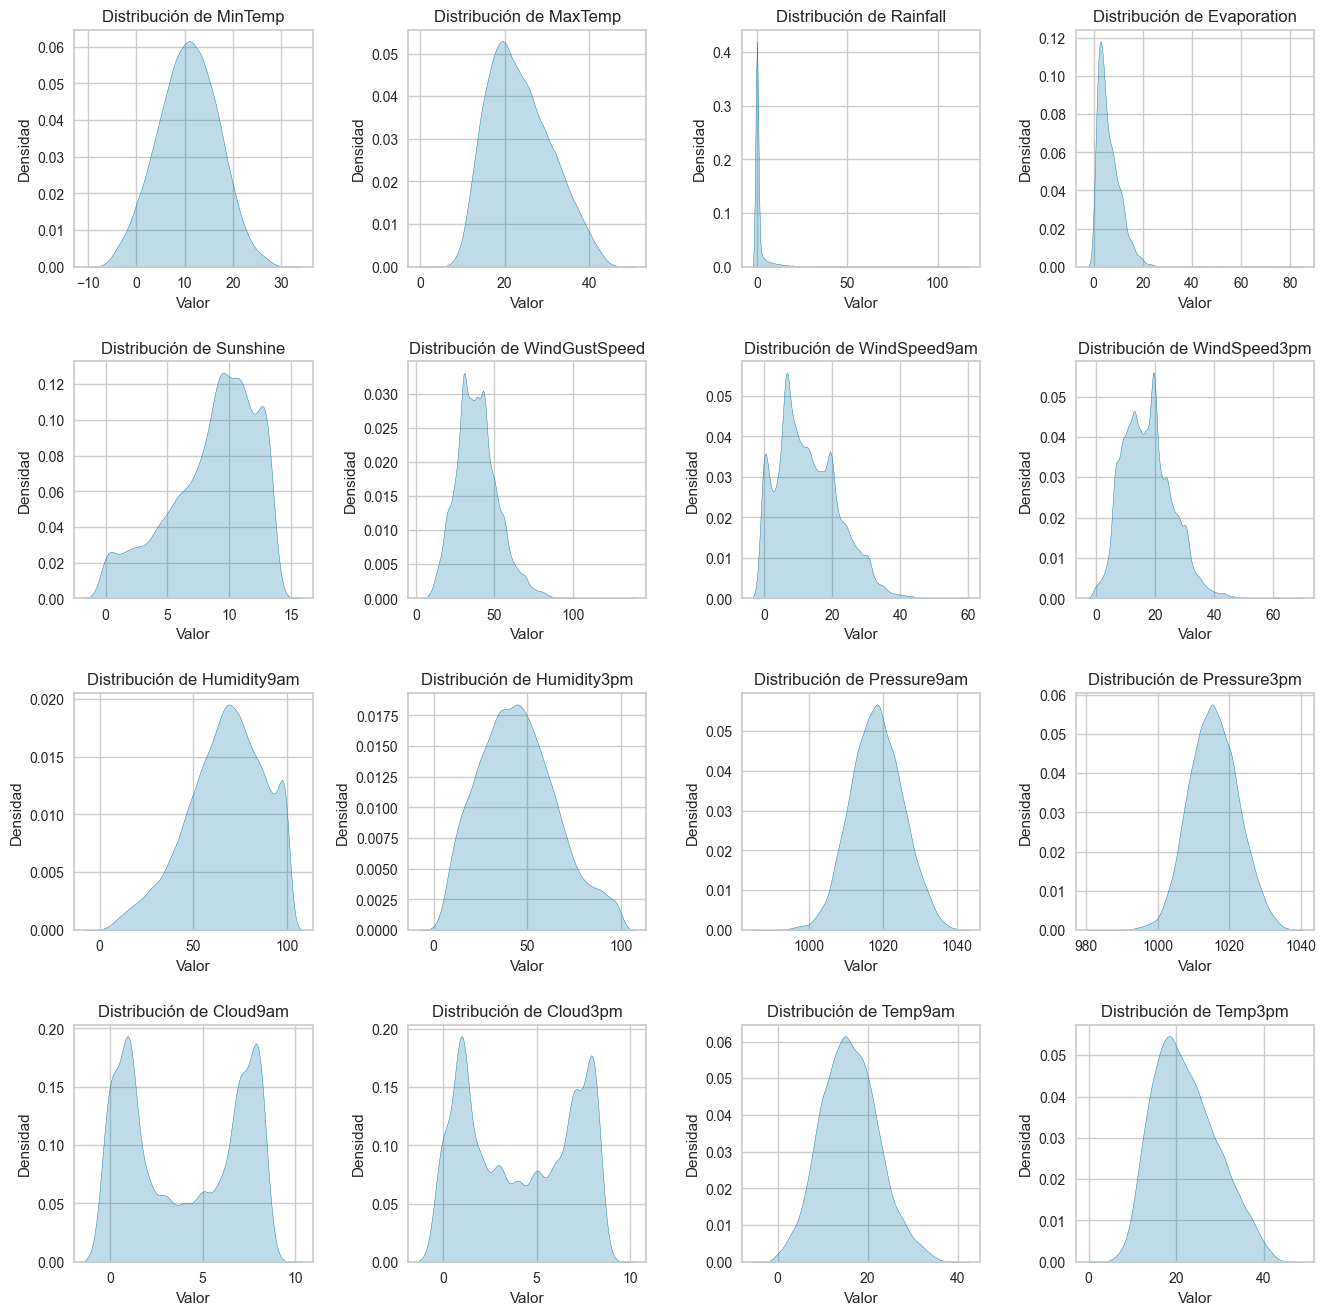

In [9]:
# Filtrar las columnas numéricas del dataframe
df_numerico = df_filtered.select_dtypes(include=['float64', 'int64'])

# Determinar el número de variables numéricas
num_vars = len(df_numerico.columns)

# Configurar la figura y las subplots
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))

# Ajustar espacio entre los gráficos
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Recorrer las columnas y plotear cada una en su propio subplot
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    sns.kdeplot(df_numerico[column], ax=axes[row, col], fill=True)
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Densidad')

# Eliminar gráficos vacíos si no se llena la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()


Al analizar las distribuciones de las variables numéricas a través de gráficos de KDE, observamos varios patrones.

1. **Distribuciones Normales**:
   Algunas variables muestran una distribución simétrica, similar a la curva de campana característica de la **distribución normal**.

2. **Distribuciones Asimétricas (Sesgo)**:
   Otras variables presentan **sesgo**, ya sea positivo o negativo.
   
3. **Distribuciones Multimodales**:
   Se observan algunas variables con **distribuciones multimodales**, es decir, con varios picos en su densidad. Esto podría sugerir la existencia de **subgrupos** lo cual es normal ya que los datos son climaticos y puede llegar a tener algo que ver con las estaciones.

4. **Presencia de Outliers**:
   Varias variables muestran distribuciones con **colas largas**, lo que indica la presencia de **outliers** lo cual nos confirma lo que fue analizado anteriormente.



## Analisis exploratorio

La modificación de las columnas **'WindDir9am'**, **'WindDir3pm'** y **'WindGustDir'** se realizó para representar correctamente la naturaleza cíclica de las direcciones del viento. La dirección del viento es una variable cíclica que tiene un ciclo completo de 360 grados, lo que implica que una dirección de 0° es casi idéntica a una de 360°.

In [10]:
columnas = ['WindDir9am', 'WindDir3pm', 'WindGustDir']

# Diccionario de mapeo de direcciones del viento a grados
wind_dir_map = {
    'N': 0,
    'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180,
    'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# Aplicar el mapeo de direcciones a grados
for col in columnas:
    df_filtered[col] = df_filtered[col].map(wind_dir_map)

# Reemplazar NaN en caso de que haya direcciones no mapeadas
df_filtered[columnas] = df_filtered[columnas].fillna(df_filtered[columnas].mean())

# Representación cíclica de las direcciones del viento
for col in columnas:
    df_filtered[col + '_sin'] = np.sin(2 * np.pi * df_filtered[col] / 360)
    df_filtered[col + '_cos'] = np.cos(2 * np.pi * df_filtered[col] / 360)

# Dropear las columnas originales si ya no las necesitas
df_filtered = df_filtered.drop(columns=columnas)

Para la variable categórica 'Location', calculamos la proporción de cada localidad en relación con la columna `RainToday`. 

In [11]:
df_filtered['Location'] = df_filtered['Location'].fillna('Categoria_Nula')

mean_encoded_location_today = df_filtered.groupby('Location')['RainToday'].mean()

df_filtered['Location'] = df_filtered['Location'].map(mean_encoded_location_today)

Al observar los valores faltantes, calculamos el porcentaje de datos faltantes en cada columna. 

In [12]:
conteo_nan = df_filtered.isnull().sum()
# Que porcentaje del total de cada columna hay valores faltantes
nan_percentage = (conteo_nan / len(df_filtered)) * 100
missing_data = pd.DataFrame({'count': conteo_nan, 'percentage': nan_percentage})
print(missing_data)

                 count  percentage
Date                 0    0.000000
Location             0    0.000000
MinTemp            144    0.493066
MaxTemp            118    0.404040
Rainfall           677    2.318096
Evaporation      20610   70.570108
Sunshine         19669   67.348057
WindGustSpeed      886    3.033727
WindSpeed9am       404    1.383325
WindSpeed3pm       371    1.270330
Humidity9am        306    1.047766
Humidity3pm        223    0.763568
Pressure9am       3372   11.545968
Pressure3pm       3362   11.511727
Cloud9am         15524   53.155282
Cloud3pm         15684   53.703133
Temp9am            151    0.517035
Temp3pm            110    0.376648
RainToday            0    0.000000
RainTomorrow         0    0.000000
WindDir9am_sin       0    0.000000
WindDir9am_cos       0    0.000000
WindDir3pm_sin       0    0.000000
WindDir3pm_cos       0    0.000000
WindGustDir_sin      0    0.000000
WindGustDir_cos      0    0.000000


Algunas variables, como 'Evaporation', 'Sunshine', 'Cloud9am' y 'Cloud3pm', tienen un porcentaje considerable de datos faltantes, mientras que otras, como 'MinTemp', 'MaxTemp' o 'Rainfall', presentan menos valores faltantes.

### Limpieza de Datos

Como primera medida, eliminaremos las filas que tengan valores nulos en la variable objetivo o aquellas que presenten 18 o más columnas con valores nulos, ya que las consideramos irrelevantes para el análisis.

In [13]:
#Mantenemos las filas que contengan 18 o menos valores nulos
df_filtered = df_filtered.dropna(thresh=18)

#Eliminamos las filas que contienen la variable Target como nula
df_filtered = df_filtered.dropna(subset=['RainTomorrow'])

A continuación, realizaremos la división de los datos, ya que consideramos que es un paso necesario en este punto. Sin embargo, continuaremos con el análisis exploratorio y la limpieza de los datos una vez realizada esta división.

### Train-Test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered.drop(columns=['RainTomorrow']), df_filtered['RainTomorrow'], test_size=0.3, random_state=42)

#Validacion
X_train, X_temp, y_train, y_temp = train_test_split(
    df_filtered.drop(columns=['RainTomorrow']),
    df_filtered['RainTomorrow'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5, 
    random_state=42
)

# Concatenar para tener dataframes completos
df_entrenamiento = pd.concat([X_train, y_train], axis=1)
df_validacion = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

Decidimos imputar las variables que tienen menos de 1000 valores faltantes utilizando la media, ya que el porcentaje que representan en relación con el total de filas es insignificante y no debería afectar el análisis o los resultados del modelo de manera considerable.

In [15]:
# Identificar las columnas con menos de 1000 nulos
cols_with_few_nans = df_entrenamiento.columns[df_entrenamiento.isnull().sum() < 1000]
medias = {}

for col in cols_with_few_nans:
    if df_entrenamiento[col].dtype in ['float64', 'int64']:  # Solo columnas numéricas
        media = df_entrenamiento[col].mean()  # Calcular la media
        df_entrenamiento[col] = df_entrenamiento[col].fillna(media) 
        medias[col] = media


In [16]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation        14282
Sunshine           13617
WindGustSpeed          0
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am         2278
Pressure3pm         2286
Cloud9am           10764
Cloud3pm           10833
Temp9am                0
Temp3pm                0
RainToday              0
WindDir9am_sin         0
WindDir9am_cos         0
WindDir3pm_sin         0
WindDir3pm_cos         0
WindGustDir_sin        0
WindGustDir_cos        0
RainTomorrow           0
dtype: int64

Todavia contamos con columnas que presentan algunos valores nulos. Antes de tomar decisiones sobre cómo manejarlas, analizaremos su distribución para evaluar si es conveniente imputarlas o eliminarlas, con el fin de tomar una decisión informada que no afecte negativamente el análisis o el rendimiento del modelo.

<AxesSubplot: xlabel='Evaporation', ylabel='Density'>

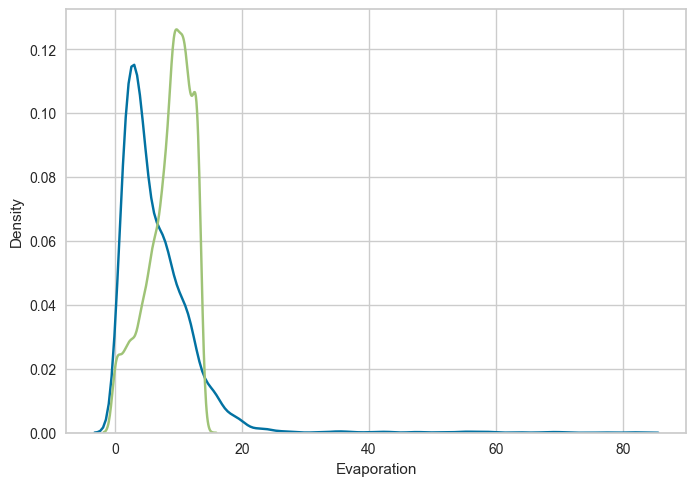

In [17]:
sns.kdeplot(df_entrenamiento["Evaporation"])
sns.kdeplot(df_entrenamiento["Sunshine"])

Podemos observar una clara distribución asimétrica a la derecha. Por lo tanto, optaremos por imputar los valores nulos utilizando la mediana, ya que este enfoque es más robusto frente a los valores atípicos y proporciona una estimación más representativa de los datos.

In [18]:
# Imputar los valores faltantes en 'Evaporation' y 'Sunshine' con la mediana
mediana_evaporation = df_entrenamiento['Evaporation'].median()
mediana_sunshine= df_entrenamiento['Sunshine'].median()

df_entrenamiento['Evaporation'] = df_entrenamiento['Evaporation'].fillna(mediana_evaporation)
df_entrenamiento['Sunshine'] = df_entrenamiento['Sunshine'].fillna(mediana_sunshine)


Procedemos a verificar las columnas restantes.

<AxesSubplot: xlabel='Pressure9am', ylabel='Density'>

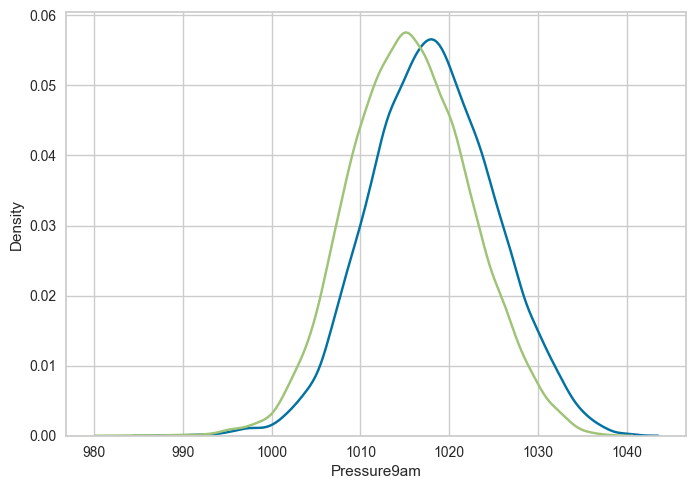

In [19]:
sns.kdeplot(df_entrenamiento["Pressure9am"])
sns.kdeplot(df_entrenamiento["Pressure3pm"])

In [20]:
columnas = ["Pressure9am", "Pressure3pm"]
for col in columnas:
    media = df_entrenamiento[col].mean()  # Calcular la media
    df_entrenamiento[col] = df_entrenamiento[col].fillna(media) 
    medias[col] = media

Utilizamos la media para imputar valores atípicos porque es una medida robusta en distribuciones simétricas, manteniendo el balance y la tendencia central de los datos sin introducir sesgos extremos.

<AxesSubplot: xlabel='Cloud9am', ylabel='Density'>

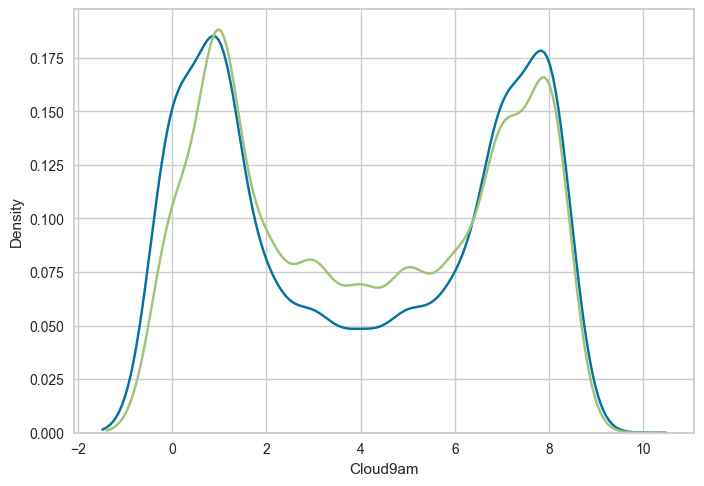

In [21]:
sns.kdeplot(df_entrenamiento["Cloud9am"])
sns.kdeplot(df_entrenamiento["Cloud3pm"])

In [22]:
# Inicializar el imputador k-NN
knn_imputer = KNNImputer(n_neighbors=5)  # Puedes ajustar el número de vecinos

# Imputar los valores nulos en las columnas 'Cloud9am' y 'Cloud3pm'
df_entrenamiento[['Cloud9am', 'Cloud3pm']] = knn_imputer.fit_transform(df_entrenamiento[['Cloud9am', 'Cloud3pm']])


En este caso como es una distribución bimodal decidimos usar KNN para imputar ya que esto permite capturar ambas "modas" de la distribución.

In [23]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date               0
Location           0
MinTemp            0
MaxTemp            0
Rainfall           0
Evaporation        0
Sunshine           0
WindGustSpeed      0
WindSpeed9am       0
WindSpeed3pm       0
Humidity9am        0
Humidity3pm        0
Pressure9am        0
Pressure3pm        0
Cloud9am           0
Cloud3pm           0
Temp9am            0
Temp3pm            0
RainToday          0
WindDir9am_sin     0
WindDir9am_cos     0
WindDir3pm_sin     0
WindDir3pm_cos     0
WindGustDir_sin    0
WindGustDir_cos    0
RainTomorrow       0
dtype: int64

#### Outliers

In [24]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: Location - Porcentaje de valores atípicos: 26.00%
Columna: MinTemp - Porcentaje de valores atípicos: 0.14%
Columna: MaxTemp - Porcentaje de valores atípicos: 0.03%
Columna: Rainfall - Porcentaje de valores atípicos: 20.08%
Columna: Evaporation - Porcentaje de valores atípicos: 29.34%
Columna: Sunshine - Porcentaje de valores atípicos: 32.55%
Columna: WindGustSpeed - Porcentaje de valores atípicos: 1.88%
Columna: WindSpeed9am - Porcentaje de valores atípicos: 0.59%
Columna: WindSpeed3pm - Porcentaje de valores atípicos: 1.33%
Columna: Humidity9am - Porcentaje de valores atípicos: 0.59%
Columna: Humidity3pm - Porcentaje de valores atípicos: 0.00%
Columna: Pressure9am - Porcentaje de valores atípicos: 1.48%
Columna: Pressure3pm - Porcentaje de valores atípicos: 1.49%
Columna: Cloud9am - Porcentaje de valores atípicos: 40.84%
Columna: Cloud3pm - Porcentaje de valores atípicos: 47.70%
Columna: Temp9am - Porcentaje de valores atípicos: 0.48%
Columna: Temp3pm - Porcentaje de valores 

Observamos que en la mayoría de las columnas no hay una cantidad significativa de valores atípicos, por lo que decidimos no realizar ningún tratamiento sobre ellos.

A continuación, analizaremos la distribución de la variable objetivo.

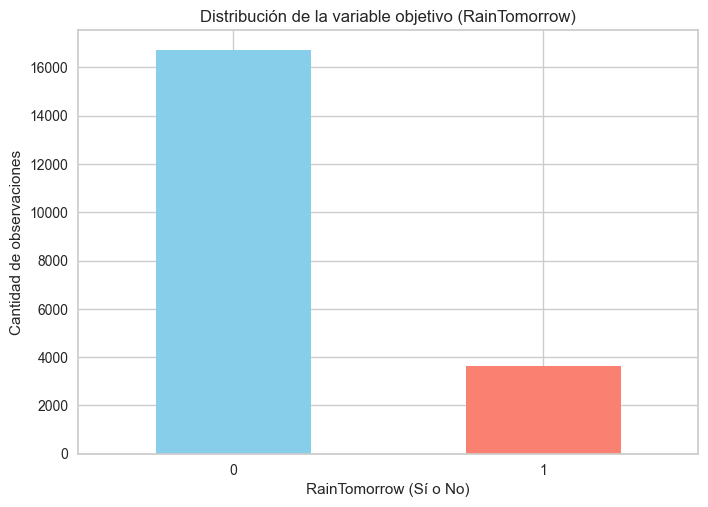

In [25]:
df_entrenamiento['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow)')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


Observamos una marcada diferencia entre los dos valores de la variable objetivo, lo que indica que el conjunto de datos **está desbalanceado**, lo cual mas adelante procederemos a balancearlo. Además, es importante analizar la tasa de aciertos en las predicciones del dataset.

True     14314
False     6026
Name: Predicción Acertada, dtype: int64


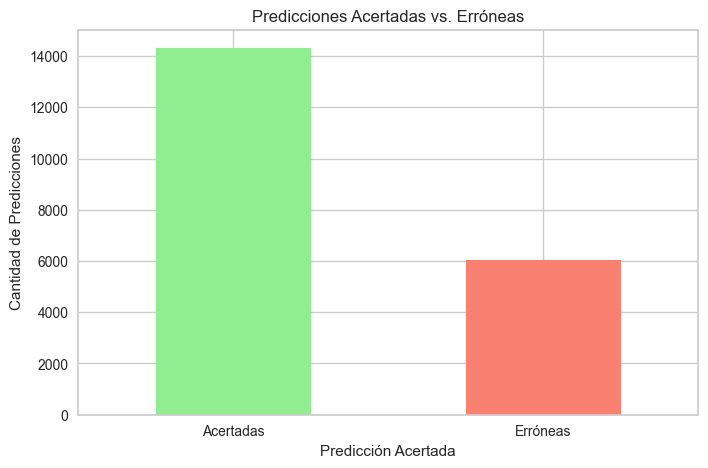

In [26]:
# Crear una copia de las columnas relevantes
df_aciertos = df_entrenamiento[['RainToday', 'RainTomorrow']].copy()

# Comparar RainToday de la fila actual con RainTomorrow de la fila anterior
# shift() mueve la columna RainTomorrow una fila hacia abajo
df_aciertos['Predicción Acertada'] = df_aciertos['RainToday'] == df_aciertos['RainTomorrow'].shift(1)

# Contar las predicciones acertadas y erróneas
conteo_aciertos = df_aciertos['Predicción Acertada'].value_counts()

# Mostrar conteo de aciertos
print(conteo_aciertos)

# Graficar los resultados
plt.figure(figsize=(8, 5))
conteo_aciertos.plot(kind='bar', color=['lightgreen', 'salmon'])

plt.title('Predicciones Acertadas vs. Erróneas')
plt.xlabel('Predicción Acertada')
plt.ylabel('Cantidad de Predicciones')
plt.xticks(ticks=[0, 1], labels=['Acertadas', 'Erróneas'], rotation=0)

plt.show()


Considerando la información proporcionada por las variables, analizamos la precisión de las 'predicciones' sobre si lloverá mañana. Observamos que se ha logrado una predicción con cierto grado de efectividad, aunque hay margen para mejorar.

### Matriz de correlación


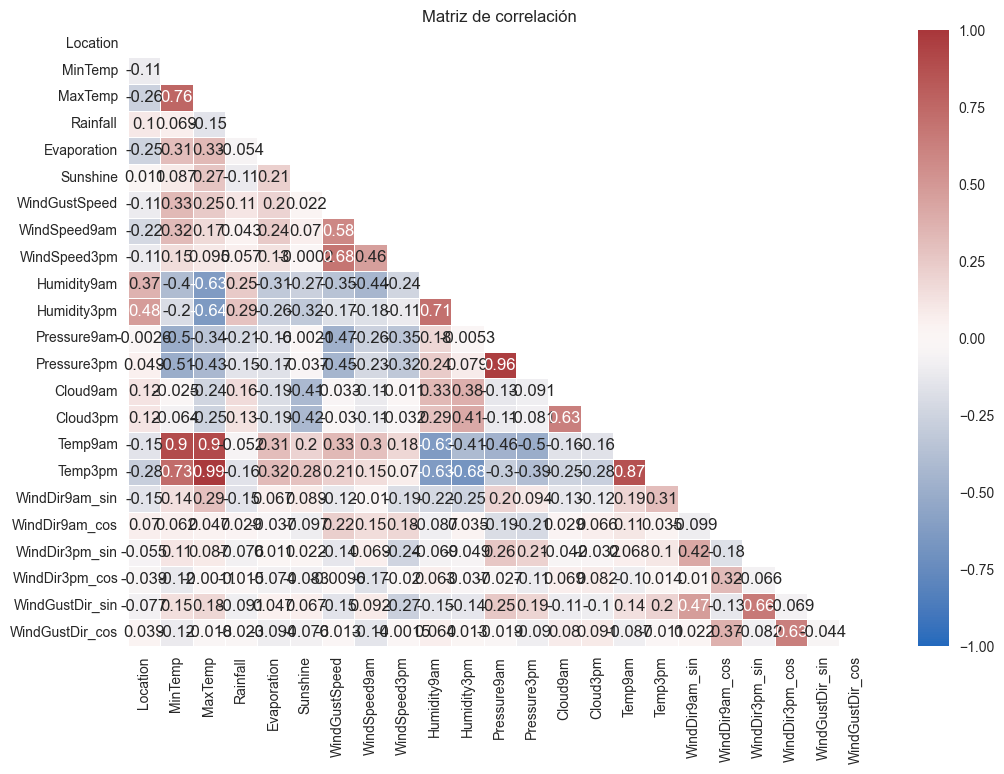

In [27]:
df_numerico = df_entrenamiento.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = df_numerico.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


Decidimos eliminar las columnas 'Temp9am' y 'Temp3pm', ya que contamos con 'MinTemp' y 'MaxTemp' para todo el día, y su correlación sugiere que son redundantes. De manera similar, considerando la correlación entre 'Pressure9am' y 'Pressure3pm', optamos por conservar solo una de ellas.

In [28]:
df_entrenamiento = df_entrenamiento.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])

### Limpieza de datos para df_test y df_validacion

Todas las imputaciones y limpiezas de datos que realizamos para el conjunto de entrenamiento también se aplicarán a los conjuntos de prueba y validación, asegurando consistencia en el procesamiento de los datos.

In [29]:
for col, media in medias.items():
    if col in df_validacion.columns:   
        df_validacion[col] = df_validacion[col].fillna(media)  
for col, media in medias.items():
    if col in df_test.columns:  
        df_test[col] = df_test[col].fillna(media)


df_test["Evaporation"] = df_test["Evaporation"].fillna(mediana_evaporation)
df_test["Sunshine"] = df_test["Sunshine"].fillna(mediana_sunshine)
df_validacion["Evaporation"] = df_validacion["Evaporation"].fillna(mediana_evaporation)
df_validacion["Sunshine"] = df_validacion["Sunshine"].fillna(mediana_sunshine)


df_test = df_test.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])
df_validacion = df_validacion.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])


df_test[['Cloud9am', 'Cloud3pm']] = knn_imputer.transform(df_test[['Cloud9am', 'Cloud3pm']])
df_validacion[['Cloud9am', 'Cloud3pm']] = knn_imputer.transform(df_validacion[['Cloud9am', 'Cloud3pm']])

Para mejorar nuestras predicciones, hemos extraído y representado cíclicamente el mes de la columna 'Date'. Transformamos el mes en dos nuevas características: el seno y el coseno del mes, lo que nos permite capturar su naturaleza cíclica (por ejemplo, enero y diciembre están cercanos). Luego, eliminamos la columna 'Date' y la columna 'Month' resultante para evitar incluirlas en análisis posteriores, como la matriz de correlación, manteniendo solo las características cíclicas.


In [30]:
# Extraer características de fecha y representar cíclicamente
for df in [df_entrenamiento, df_validacion, df_test]:
    df['Month'] = df['Date'].dt.month  # Extraer el mes
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)  # Representación seno
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)  # Representación coseno
    df.drop(columns=['Date', 'Month'], inplace=True)  # Eliminar columnas innecesarias


In [31]:
df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20340 entries, 106407 to 26625
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Location         20340 non-null  float64
 1   MinTemp          20340 non-null  float64
 2   MaxTemp          20340 non-null  float64
 3   Rainfall         20340 non-null  float64
 4   Evaporation      20340 non-null  float64
 5   Sunshine         20340 non-null  float64
 6   WindGustSpeed    20340 non-null  float64
 7   WindSpeed9am     20340 non-null  float64
 8   WindSpeed3pm     20340 non-null  float64
 9   Humidity9am      20340 non-null  float64
 10  Humidity3pm      20340 non-null  float64
 11  Pressure3pm      20340 non-null  float64
 12  Cloud9am         20340 non-null  float64
 13  Cloud3pm         20340 non-null  float64
 14  RainToday        20340 non-null  int32  
 15  WindDir9am_sin   20340 non-null  float64
 16  WindDir9am_cos   20340 non-null  float64
 17  WindDir

## Escalado

Optamos por utilizar **RobustScaler** debido a que aún contamos con algunos valores atípicos. Esto permitirá que el algoritmo de aprendizaje automático sea más estable.

In [32]:
scaler = RobustScaler()

df_train_scaled = pd.DataFrame(scaler.fit_transform(df_entrenamiento), columns=df_entrenamiento.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
df_val_scaled = pd.DataFrame(scaler.transform(df_validacion), columns=df_validacion.columns)

df_train_scaled.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,RainToday,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,WindGustDir_sin,WindGustDir_cos,RainTomorrow,Month_sin,Month_cos
0,-4.283947,-0.264368,-0.790909,0.0,-0.8,-8.0,-0.2500,0.461538,-0.181818,-0.214286,...,0.0,4.966058e-01,-1.393260e-16,1.000000,-0.500000,0.500000,-0.500000,0.0,0.500000,-0.633975
1,0.317778,0.643678,0.354545,4.0,0.0,0.0,-0.9375,-0.846154,-0.363636,0.964286,...,1.0,7.327644e-02,-3.161910e-01,0.351153,0.707107,0.500000,0.500000,0.0,0.866025,-0.366025
2,0.054764,0.781609,0.872727,0.0,2.4,0.3,-0.3750,1.307692,0.272727,-1.821429,...,0.0,-1.018749e-16,8.198271e-01,-0.496606,-0.270598,0.270598,0.653281,0.0,0.866025,-0.366025
3,0.574319,0.793103,1.236364,0.0,0.0,0.0,0.2500,-0.307692,-0.181818,-0.821429,...,0.0,-3.511533e-01,-3.873467e-01,-0.496606,-0.270598,-0.707107,0.000000,0.0,0.500000,0.633975
4,0.317778,0.160920,0.000000,0.0,0.0,0.0,-0.5625,-0.384615,-0.181818,0.607143,...,0.0,4.966058e-01,4.802436e-01,0.702307,0.653281,0.500000,0.500000,0.0,0.500000,-0.633975


## Modelado

In [33]:
X_train_scaled = df_train_scaled.drop('RainTomorrow', axis=1)
y_train_scaled = df_train_scaled['RainTomorrow']

X_test_scaled = df_test_scaled.drop('RainTomorrow', axis=1)
y_test_scaled = df_test_scaled['RainTomorrow']

X_val_scaled = df_val_scaled.drop('RainTomorrow', axis=1)
y_val_scaled = df_val_scaled['RainTomorrow']

### Previo al balanceo

Vamos a evaluar las métricas del dataset antes de balancearlo. Luego, realizaremos el balanceo y compararemos los resultados.

Aplicamos 'LogisticRegression'

In [34]:
# Inicializar y entrenar el modelo
model = LogisticRegression()
model.fit(X_train_scaled, y_train_scaled)

LogisticRegression()

Procedemos a calcular nuestras métricas adecuadas.

In [35]:
# Predicciones
y_pred = model.predict(X_test_scaled)  
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Cálculo de métricas
accuracy = accuracy_score(y_test_scaled, y_pred)
precision = precision_score(y_test_scaled, y_pred)
recall = recall_score(y_test_scaled, y_pred)
f1 = f1_score(y_test_scaled, y_pred)

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.87
Precision: 0.73
Recall: 0.48
F1 Score: 0.58


Calculamos nuestra curva ROC

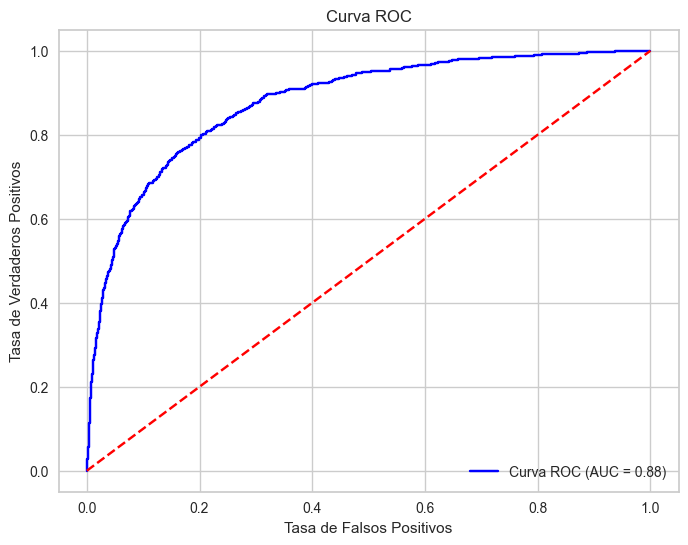

Mejor umbral: 0.20


In [36]:
# Cálculo de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_proba)
roc_auc = roc_auc_score(y_test_scaled, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Mejor umbral: {optimal_threshold:.2f}")

Verificamos la matriz de confusión

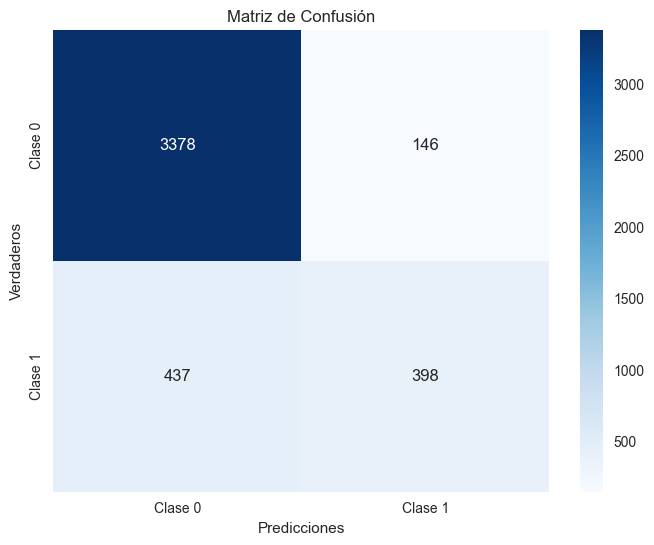

In [37]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_scaled, y_pred)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

### Posterior al balanceo

Aplicamos SMOTE para balancear las clases ya que este método genera nuevas instancias de la clase minoritaria mediante la creación de muestras sintéticas. En lugar de simplemente replicar las instancias de la clase minoritaria, SMOTE selecciona ejemplos de la clase minoritaria y genera nuevos puntos de datos a lo largo de las líneas que conectan estos ejemplos con sus vecinos más cercanos. Esto ayuda a evitar el sobreajuste que puede ocurrir al duplicar instancias y mejora el rendimiento del modelo, especialmente en modelos sensibles al desequilibrio de clases.


In [38]:
# Aplicar SMOTE para balancear la clase minoritaria
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_scaled)


Verificamos que se haya balanceado correctamente.

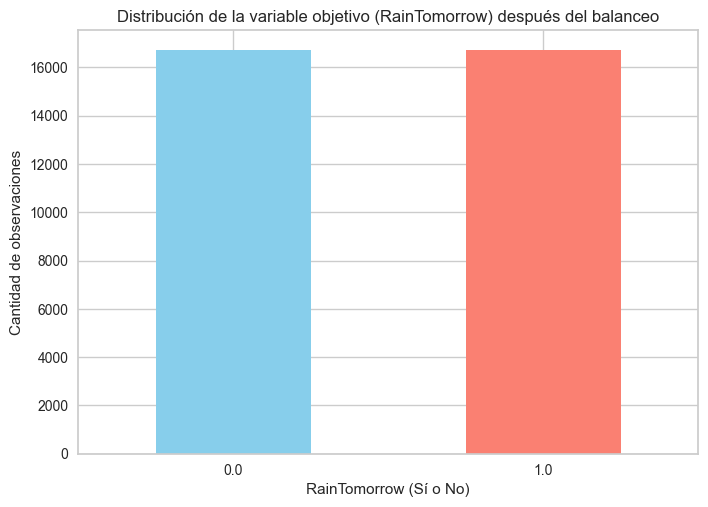

In [39]:
# Crear un dataframe con los datos balanceados
df_balanceado = pd.DataFrame({'RainTomorrow': y_train_balanced})

# Graficar la nueva distribución
df_balanceado['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow) después del balanceo')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


In [40]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [41]:
# Predicciones
y_pred_logistic = model_logistic.predict(X_test_scaled)  
y_pred_proba_logistic = model_logistic.predict_proba(X_test_scaled)[:, 1]

# Cálculo de métricas
accuracy_logistic = accuracy_score(y_test_scaled, y_pred_logistic)
precision_logistic = precision_score(y_test_scaled, y_pred_logistic)
recall_logistic = recall_score(y_test_scaled, y_pred_logistic)
f1_logistic = f1_score(y_test_scaled, y_pred_logistic)

# Mostrar las métricas
print(f"Accuracy: {accuracy_logistic:.2f}")
print(f"Precision: {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print(f"F1 Score: {f1_logistic:.2f}")



Accuracy: 0.81
Precision: 0.50
Recall: 0.77
F1 Score: 0.61


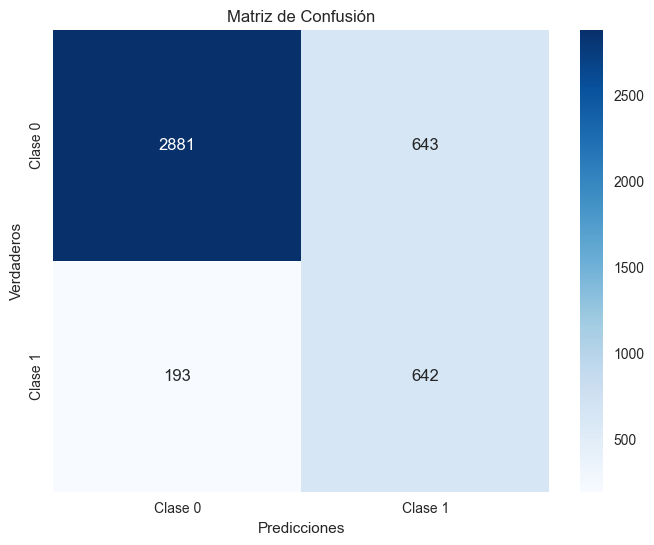

In [42]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_scaled, y_pred_logistic)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

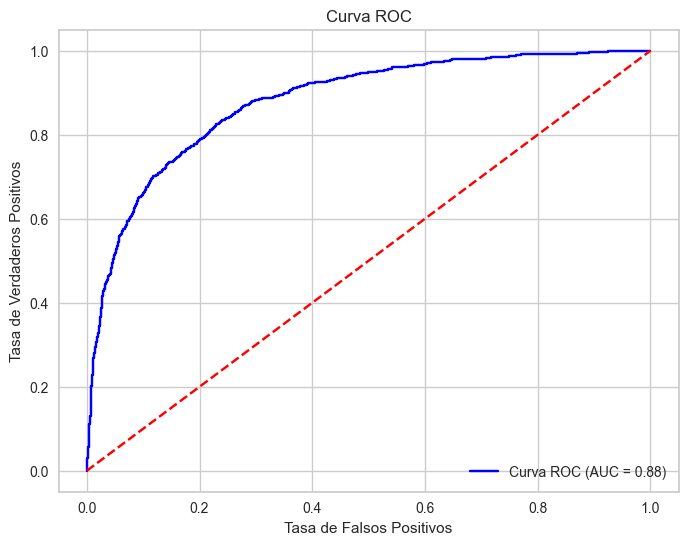

Mejor umbral: 0.42


In [43]:
# Cálculo de la curva ROC
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test_scaled, y_pred_proba_logistic)
roc_auc_logistic = roc_auc_score(y_test_scaled, y_pred_proba_logistic)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx_logistic = np.argmax(tpr_logistic - fpr_logistic)
optimal_threshold_logistic = thresholds_logistic[optimal_idx_logistic]
print(f"Mejor umbral: {optimal_threshold_logistic:.2f}")


Al evaluar el modelo antes de balancear los datos, se observó un buen desempeño general en términos de exactitud y precisión. Sin embargo, el bajo valor de recall sugiere que el modelo tenía dificultades para identificar correctamente los casos de la clase minoritaria, probablemente debido a un sesgo hacia la clase mayoritaria.

Después de balancear los datos, se evidenciaron cambios significativos en las métricas. Aunque la exactitud y la precisión disminuyeron, el recall aumentó considerablemente, lo que indica que el modelo se volvió más efectivo en la detección de la clase minoritaria. La puntuación F1 también mostró una mejora leve, reflejando un mayor equilibrio entre la precisión y el recall.

Estos resultados demuestran que el balanceo permitió al modelo enfocarse mejor en ambas clases, especialmente en la minoritaria, aunque esto implicó un sacrificio en la capacidad para mantener predicciones precisas en general.

## Modelo Base

Para nuestro modelo base, decidimos utilizar el **DummyClassifier** con la estrategia "stratified". A continuación, procederemos a realizar los mismos pasos que en el modelo anterior, evaluando tanto el modelo base balanceado como el desbalanceado.

### Previo al balanceo

In [44]:
# Inicializamos el DummyClassifier con la estrategia 'stratified'
dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=42)

# Entrenar el modelo Dummy
dummy_clf_stratified.fit(X_train_scaled, y_train_scaled)

# Predecir probabilidades en lugar de clases
y_pred_dummy_proba = dummy_clf_stratified.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de la clase positiva

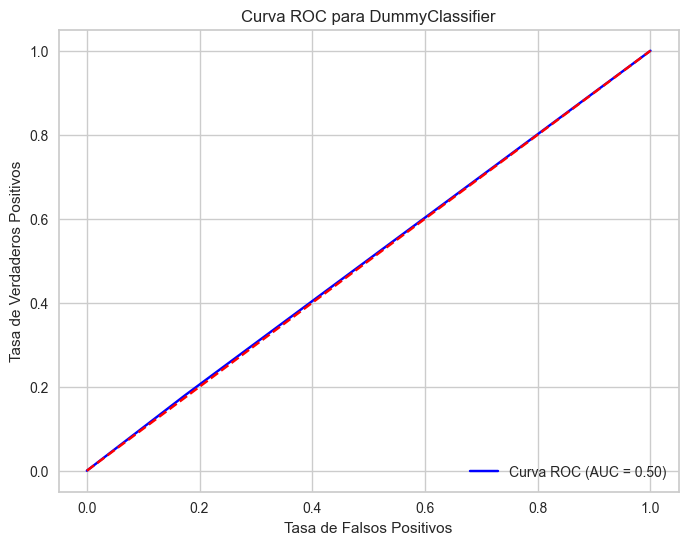

In [45]:
# Calculamos la curva ROC y encontrar el AUC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test_scaled, y_pred_dummy_proba)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_dummy, tpr_dummy, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_dummy))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para DummyClassifier')
plt.legend(loc='lower right')
plt.show()

In [46]:
# Encontramos el mejor umbral
optimal_idx_dummy = np.argmax(tpr_dummy - fpr_dummy)  # Mejor umbral donde TPR - FPR es máximo
optimal_threshold_dummy = thresholds_dummy[optimal_idx_dummy]

print(f"Mejor umbral: {optimal_threshold:.2f}")

Mejor umbral: 0.20


In [47]:
# Calculamos métricas con las clases generadas por el umbral óptimo
accuracy_dummy = accuracy_score(y_test_scaled, y_pred_dummy_proba)
precision_dummy = precision_score(y_test_scaled, y_pred_dummy_proba)
recall_dummy = recall_score(y_test_scaled, y_pred_dummy_proba)
f1_dummy = f1_score(y_test_scaled, y_pred_dummy_proba)

print("\nMétricas con DummyClassifier:")
print(f"Accuracy: {accuracy_dummy:.2f}")
print(f"Precision: {precision_dummy:.2f}")
print(f"Recall: {recall_dummy:.2f}")
print(f"F1 Score: {f1_dummy:.2f}")


Métricas con DummyClassifier:
Accuracy: 0.70
Precision: 0.20
Recall: 0.18
F1 Score: 0.19


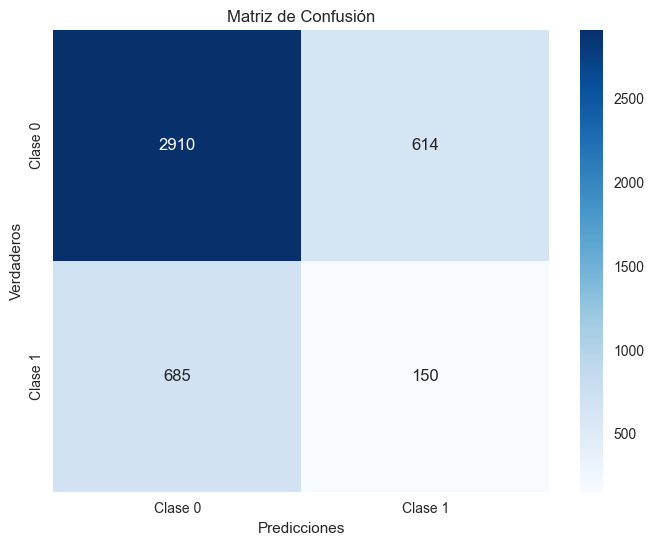

In [48]:
# Matriz de confusión
conf_matrix_dummy = confusion_matrix(y_test_scaled, y_pred_dummy_proba)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

### Posterior al balanceo

In [49]:
# Inicializar el DummyClassifier con la estrategia 'stratified'
dummy_clf_stratified_balanced = DummyClassifier(strategy='stratified', random_state=42)

# Entrenar el modelo Dummy
dummy_clf_stratified_balanced.fit(X_train_balanced, y_train_balanced)

# Predecir probabilidades en lugar de clases
y_pred_dummy_proba_balanced = dummy_clf_stratified_balanced.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de la clase positiva

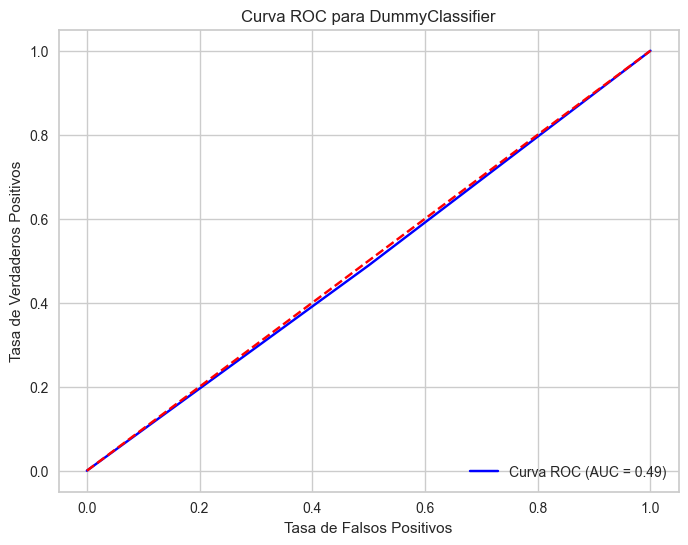

In [50]:
# Calcular la curva ROC y encontrar el AUC
fpr_dummy_balanced, tpr_dummy_balanced, thresholds_dummy_balanced = roc_curve(y_test_scaled, y_pred_dummy_proba_balanced)
roc_auc_dummy_balanced = auc(fpr_dummy_balanced, tpr_dummy_balanced)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_dummy_balanced, tpr_dummy_balanced, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_dummy_balanced))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para DummyClassifier')
plt.legend(loc='lower right')
plt.show()

In [51]:
# Encontrar el mejor umbral
optimal_idx_dummy_balanced = np.argmax(tpr_dummy_balanced - fpr_dummy_balanced)  # Mejor umbral donde TPR - FPR es máximo
optimal_threshold_dummy_balanced = thresholds_dummy_balanced[optimal_idx_dummy_balanced]

print(f"Mejor umbral: {optimal_threshold_dummy_balanced:.2f}")

Mejor umbral: inf


In [52]:
# Calcular métricas con las clases generadas por el umbral óptimo
accuracy_dummy_balanced= accuracy_score(y_test_scaled, y_pred_dummy_proba_balanced)
precision_dummy_balanced = precision_score(y_test_scaled, y_pred_dummy_proba_balanced)
recall_dummy_balanced = recall_score(y_test_scaled, y_pred_dummy_proba_balanced)
f1_dummy_balanced = f1_score(y_test_scaled, y_pred_dummy_proba_balanced)

print("\nMétricas con DummyClassifier:")
print(f"Accuracy: {accuracy_dummy_balanced:.2f}")
print(f"Precision: {precision_dummy_balanced:.2f}")
print(f"Recall: {recall_dummy_balanced:.2f}")
print(f"F1 Score: {f1_dummy_balanced:.2f}")




Métricas con DummyClassifier:
Accuracy: 0.50
Precision: 0.19
Recall: 0.49
F1 Score: 0.27


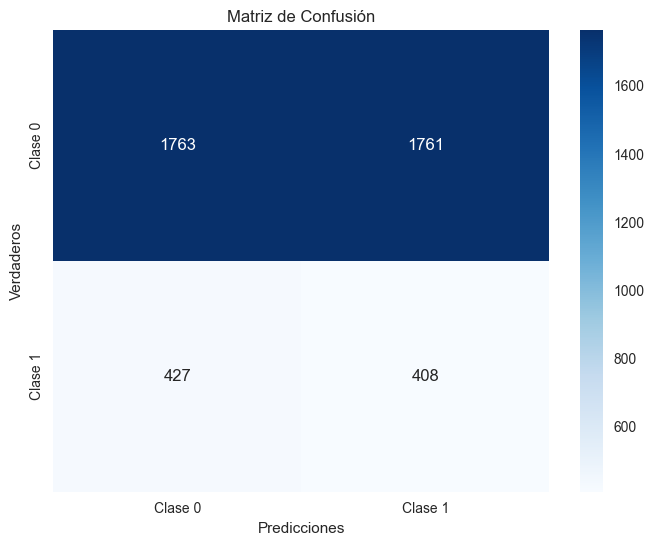

In [53]:
# Matriz de confusión
conf_matrix_dummy_balanced = confusion_matrix(y_test_scaled, y_pred_dummy_proba_balanced)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()


Al evaluar el modelo base utilizando el **DummyClassifier** antes de balancear los datos, las métricas indicaron un rendimiento limitado. La precisión y el recall fueron bajos, interpretando que el modelo tenía dificultades para identificar correctamente las instancias de la clase positiva. La matriz de confusión reveló que el modelo estaba prediciendo en gran medida la clase mayoritaria.

Después de balancear los datos, se observó una disminución en la precisión general del modelo base, lo que indica que, aunque el recall mejoró, el modelo seguía sin ser efectivo en la identificación de la clase positiva. La puntuación F1 también mostró una leve mejora, pero las métricas siguieron indicando un rendimiento subóptimo. El umbral óptimo se encuentra como `inf`, lo que refuerza que el modelo no estaba capturando adecuadamente la clase minoritaria, incluso después del balanceo.


## Optimización de hiperparametros


Decidimos utilizar `Random Search` porque es ideal para nuestro caso, ya que contamos con un gran volumen de datos. Esta técnica selecciona combinaciones de hiperparámetros de manera aleatoria, lo cual nos permite explorar un amplio rango del espacio de búsqueda sin probar todas las combinaciones posibles. Además, `Random Search` ofrece resultados eficientes en menos tiempo cuando el rango de los hiperparámetros es amplio y no conocemos de antemano los valores óptimos.


In [54]:
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],  
    'solver': ['lbfgs', 'liblinear', 'saga'], 
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 500],
    'tol': [0.0001, 0.001, 0.01],
    'fit_intercept': [True, False],
    'class_weight': ['balanced'],
    'l1_ratio': [0.5, 0.7]  # solo se usa cuando la penalidad es 'elasticnet'
}


# Configura el modelo con RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=LogisticRegression(),
                                   param_distributions=param_grid,
                                   n_iter=10,                   # Número de combinaciones a probar
                                   scoring='f1',                # Métrica para optimizar
                                   cv=5,                        # Número de pliegues de validación cruzada
                                   random_state=42)

# Entrena el RandomizedSearchCV
random_search.fit(X_train_balanced, y_train_balanced)

# Obtén el mejor modelo encontrado
best_logistic_model = random_search.best_estimator_

# Usa el mejor modelo para hacer predicciones
y_pred_logistic = best_logistic_model.predict(X_test_scaled)
y_pred_proba_logistic = best_logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calcula las métricas
accuracy_logistic = accuracy_score(y_test_scaled, y_pred_logistic)
precision_logistic = precision_score(y_test_scaled, y_pred_logistic)
recall_logistic = recall_score(y_test_scaled, y_pred_logistic)
best_f1_logistic = f1_score(y_test_scaled, y_pred_logistic)

# Muestra las métricas
print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Accuracy: {accuracy_logistic:.2f}")
print(f"Precision: {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print(f"F1 Score: {f1_logistic:.2f}")



Mejores parámetros: {'tol': 0.001, 'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 500, 'l1_ratio': 0.7, 'fit_intercept': False, 'class_weight': 'balanced', 'C': 10}
Accuracy: 0.76
Precision: 0.43
Recall: 0.84
F1 Score: 0.61


**Antes de la optimización de los hiperparámetros**:  
- *Accuracy*: 0.81  
- *Precision*: 0.50  
- *Recall*: 0.77  
- *F1 Score*: 0.61  

**Después de la optimización de los hiperparámetros** (con los mejores parámetros encontrados: {'tol': 0.001, 'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 500, 'l1_ratio': 0.7, 'fit_intercept': False, 'class_weight': 'balanced', 'C': 10}):  
- *Accuracy*: 0.76  
- *Precision*: 0.43  
- *Recall*: 0.84  
- *F1 Score*: 0.61  

### Análisis de Resultados  

La optimización de los hiperparámetros aumentó significativamente el *recall*, mejorando la capacidad del modelo para identificar instancias de la clase positiva. Sin embargo, esto se logró a costa de una reducción en la *accuracy* y la *precision*, indicando que el modelo comete más falsos positivos.  

El *F1 Score* permaneció constante, lo que sugiere que, a pesar de la caída en precisión, el modelo mantiene un equilibrio razonable entre *recall* y *precision*. Este nuevo ajuste puede ser preferible si el objetivo principal es maximizar la detección de la clase positiva, incluso sacrificando cierta exactitud general.

## SHAP

### Local

In [55]:
feature_names=df_train_scaled.drop('RainTomorrow', axis=1).columns.values
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(model, X_train_balanced, feature_names=feature_names)
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)
index=2

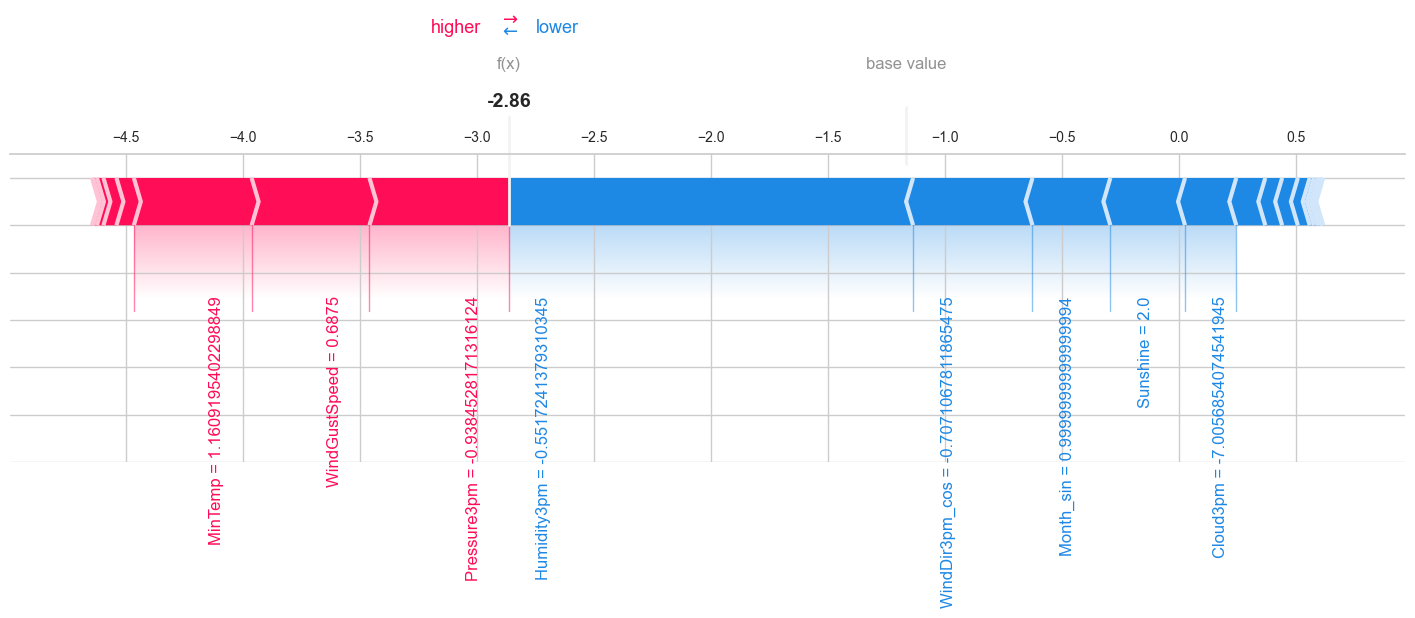

In [56]:
shap.force_plot(explainer.expected_value, shap_values[index],
                X_test_scaled.iloc[index],
                matplotlib=True, figsize=(18, 4), text_rotation=90)

- **Predicción Final (-2.86)**: Es el valor estimado por el modelo para este caso específico después de tener en cuenta todas las características. El valor negativo indica que el modelo predice que el evento de interés (por ejemplo, lluvia al día siguiente) es poco probable.

### **Características que Incrementan la Predicción (en rojo)**:
   - `MinTemp`: La temperatura mínima contribuye significativamente a incrementar la predicción, diciendonos que temperaturas más bajas podrían estar asociadas con mayor probabilidad del evento.
   - `WindGustSpeed`: La velocidad de las ráfagas de viento es un factor que aumenta considerablemente a la predicción, indicando que estas condiciones están asociadas a un mayor riesgo del evento de interés.
   - `Pressure3pm`: Lo mismo pasa con la presión a las 3 pm.

Estas características están aumentando el valor final, empujándolo hacia una mayor probabilidad del evento.

### **Características que Disminuyen la Predicción (en azul)**:
   - `Cloud3pm`: La cobertura de nubes a las 3 pm tiene la mayor contribución negativa, lo que sugiere que menos nubes están asociadas con condiciones que no favorecen el evento.
   - `Sunshine`: La cantidad de horas de sol también disminuye significativamente la predicción, indicando una relación inversa entre la luz solar y el evento.
   - `Humidity3pm`, `WindDir3pm_cos` y otros factores también contribuyen negativamente pero en menor medida, reforzando que estas condiciones no son indicativas del evento de interés.

### **Interpretación**:
1. **Factores que incrementan la predicción**:
   - **Velocidad de ráfagas (WindGustSpeed)**: Indica inestabilidad atmosférica, que podría estar asociada con el evento.
   - **Temperatura mínima (MinTemp)**: Temperaturas bajas favorecen condiciones propicias para el evento.
   - **Presión (Pressure3pm)**: Un aumento podría estar relacionado con cambios atmosféricos que favorecen el evento.

2. **Factores que disminuyen la predicción**:
   - **Cobertura de nubes (Cloud3pm)**: Indica que la ausencia de nubes reduce la probabilidad del evento.
   - **Horas de sol (Sunshine)**: Mayor luz solar tiende a estar asociada con condiciones más secas y estables.
   - **Humedad y dirección del viento**: Contribuyen negativamente, posiblemente indicando estabilidad atmosférica desfavorable para el evento. 


In [57]:
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)

In [58]:
print(shap_values[1].shape)  # Verifica el tamaño de los valores SHAP para la clase 1 (positiva)



(23,)


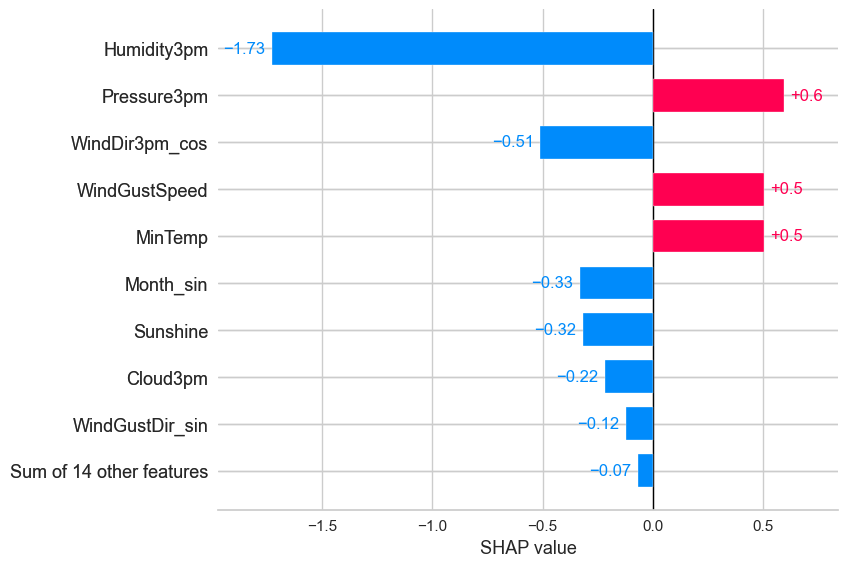

In [59]:
shap.plots.bar(explanation)


- **Humidity3pm** tiene el valor SHAP negativo más alto (-1.73), lo que indica que esta característica contribuye significativamente a disminuir la probabilidad del evento de interés (por ejemplo, lluvia). Es la característica más influyente en esta instancia en sentido negativo.

- **Pressure3pm** tiene el valor SHAP positivo más alto (+0.6), lo que significa que contribuye de manera importante a aumentar la predicción del evento. Junto con **MinTemp** y **WindGustSpeed** (ambas con valores SHAP de +0.5), estas características están empujando la predicción hacia una mayor probabilidad del evento.

- **WindDir3pm_cos** tiene un impacto negativo moderado (-0.51), reduciendo la probabilidad del evento de interés, mientras que características como **Month_sin** (-0.33) y **Sunshine** (-0.32) también tienen efectos negativos pero con menor intensidad.

- **Sum of 14 other features** representa el impacto acumulado de características con menor contribución individual. Su influencia total es pequeña en comparación con las principales.

### Interpretación:
1. **Factores que incrementan la predicción**:
   - **Pressure3pm**: Una presión más alta está asociada con una mayor probabilidad del evento, según el modelo.
   - **MinTemp y WindGustSpeed**: Indican que temperaturas mínimas más bajas y ráfagas de viento más intensas también favorecen el evento.

2. **Factores que disminuyen la predicción**:
   - **Humidity3pm**: La humedad a las 3 pm juega un papel clave en reducir la probabilidad, lo que podría significar que en este contexto específico, niveles altos de humedad no están asociados al evento.
   - **Sunshine y Cloud3pm**: Cantidades mayores de luz solar y nubes moderadas parecen correlacionarse con menores probabilidades del evento.


### Global

In [60]:
explanation_global = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_scaled)

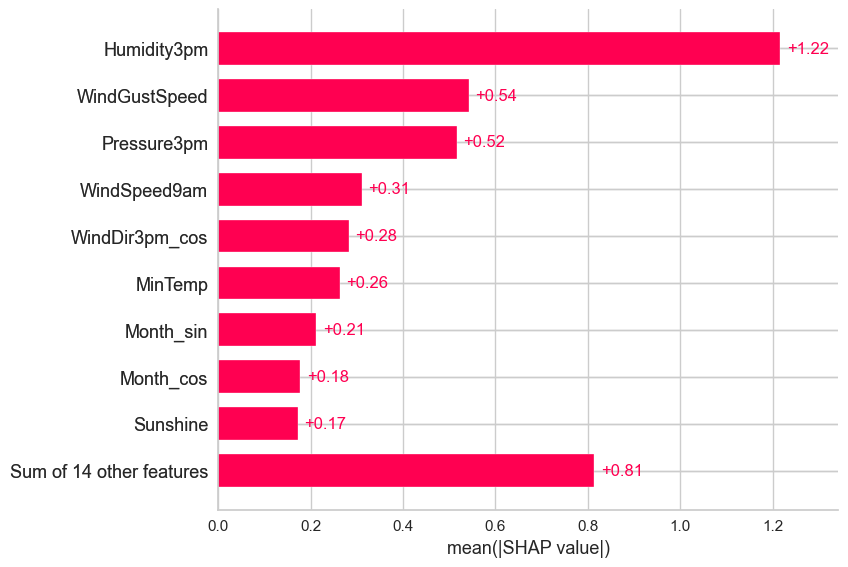

In [61]:
shap.plots.bar(explanation_global)


- **Humidity3pm** tiene el valor de SHAP más alto (+1.22), lo que indica que esta variable es la más influyente para la predicción del modelo. Esto sugiere que niveles altos o bajos de humedad a las 3 p.m. tienen un impacto significativo en aumentar o disminuir la probabilidad de lluvia.

- **WindGustSpeed** y **Pressure3pm** también tienen una influencia importante, con valores de SHAP de +0.54 y +0.52, respectivamente. Esto implica que estas variables capturan patrones relevantes que el modelo utiliza para ajustar sus predicciones, aunque su impacto es menor que el de la humedad.

- **WindSpeed9am** y **WindDir3pm_cos** tienen valores de SHAP más bajos (+0.31 y +0.28, respectivamente). Esto indica que aunque son relevantes, su contribución al modelo es moderada en comparación con las principales características.

- Variables como **MinTemp**, **Month_sin**, **Month_cos** y **Sunshine** tienen un impacto menor, con valores de SHAP que oscilan entre +0.26 y +0.17. Esto sugiere que estas variables tienen menos influencia directa sobre las predicciones, pero aún aportan información útil.

**"Sum of 14 other features"**:  
- Este grupo representa el impacto combinado de varias características menos importantes, con un valor de SHAP acumulado de +0.82. Esto indica que aunque estas variables tienen un peso menor individualmente, su contribución colectiva es considerable para el modelo.



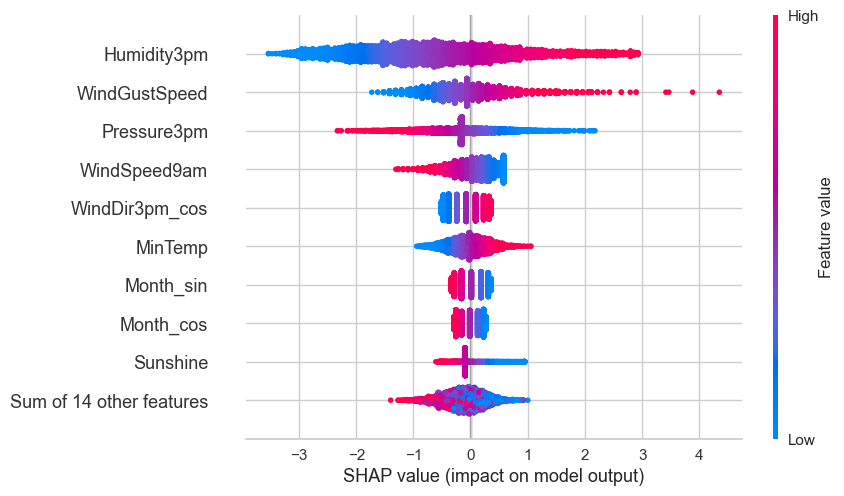

In [62]:
shap.plots.beeswarm(explanation_global)

- **Humidity3pm** muestra un rango amplio de valores SHAP, lo que indica que tiene el impacto más significativo en las predicciones del modelo. Los puntos en rojo representan valores altos de la característica, lo que generalmente contribuye de manera positiva a las predicciones, mientras que los puntos en azul (valores bajos) tienen un efecto negativo.

- **WindGustSpeed** y **Pressure3pm** también presentan un rango notable de valores SHAP. Esto significa que estas variables afectan de manera importante las predicciones, aunque su impacto es menor en comparación con **Humidity3pm**. Los valores altos (en rojo) parecen contribuir más consistentemente a predicciones positivas.

- **WindSpeed9am** y **WindDir3pm_cos** tienen un rango más limitado en los valores SHAP. Esto sugiere que su impacto es moderado, aunque todavía relevante. En el caso de **WindSpeed9am**, valores más altos (en rojo) tienden a incrementar las predicciones, mientras que valores más bajos (en azul) las reducen.

- Variables como **MinTemp**, **Month_sin**, **Month_cos** y **Sunshine** tienen menor dispersión en sus valores SHAP, lo que indica que tienen un impacto más específico y localizado en las predicciones. No obstante, los colores rojo y azul sugieren que estas características podrían estar interactuando con otras variables en el modelo.

**"Sum of 14 other features"**:  
- Este agrupamiento de características menos importantes tiene una dispersión notable, aunque su rango de valores SHAP es más limitado. Esto implica que el impacto combinado de estas variables es menor y más consistente en comparación con las principales.



## AutoML

Elegimos PyCaret porque simplifica el flujo de trabajo de Machine Learning. Nos permite probar varios modelos y aplicar técnicas de preprocesamiento de forma rápida y sin necesidad de escribir demasiado código. Además, facilita la comparación de modelos y la optimización de hiperparámetros de manera automática.

Otra razón es que tuvimos problemas al intentar implementar AutoML con otras bibliotecas, mientras que PyCaret no presentó esos mismos errores. Decidimos usar el dataset en crudo, ya que PyCaret se encarga del preprocesamiento automáticamente. Esto nos permite comparar si nuestro preprocesamiento manual fue efectivo en relación con el de PyCaret.

In [63]:
df_crudo = df_clima.copy()
df_crudo = df_filtered.dropna(subset=['RainTomorrow'])

# Configuración de PyCaret en el dataset crudo
exp_crudo = setup(data=df_crudo, target='RainTomorrow',
                  train_size=0.7,
                  normalize=True,          
                  fix_imbalance=True,      
                  session_id=123)          

# Comparar modelos en el dataset crudo
best_model_crudo = compare_models()

,Description,Value
0,Session id,123
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(29058, 26)"
4,Transformed data shape,"(41982, 28)"
5,Transformed train set shape,"(33264, 28)"
6,Transformed test set shape,"(8718, 28)"
7,Numeric features,24
8,Date features,1
9,Rows with missing values,79.7%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8857,0.9041,0.5820,0.7364,0.6500,0.5828,0.5887,0.7280
et,Extra Trees Classifier,0.8825,0.9012,0.5949,0.7133,0.6486,0.5788,0.5823,1.6360
rf,Random Forest Classifier,0.8797,0.9000,0.6114,0.6931,0.6495,0.5772,0.5790,3.7960
gbc,Gradient Boosting Classifier,0.8728,0.8891,0.6203,0.6612,0.6399,0.5628,0.5633,7.1530
ada,Ada Boost Classifier,0.8540,0.8685,0.6230,0.5956,0.6086,0.5190,0.5194,1.7230
qda,Quadratic Discriminant Analysis,0.8264,0.8622,0.7271,0.5174,0.6044,0.4973,0.5092,0.2320
ridge,Ridge Classifier,0.8234,0.8910,0.7727,0.5105,0.6147,0.5063,0.5247,0.1890
lda,Linear Discriminant Analysis,0.8234,0.8910,0.7727,0.5104,0.6146,0.5062,0.5246,0.3480
lr,Logistic Regression,0.8182,0.8922,0.7880,0.5012,0.6126,0.5014,0.5234,1.9190
dummy,Dummy Classifier,0.8177,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1990


In [64]:
# Extraer resultados de comparación
results = pull()

# Guardar el F1-score del mejor modelo
best_f1_automl = results.loc[results.index[0], 'F1']  # Fila 0, columna F1
print(f"Mejor F1-score (AutoML): {best_f1_automl}")

Mejor F1-score (AutoML): 0.65


### Resumen de los Resultados Obtenidos con PyCaret

1. **Estructura y Preprocesamiento de Datos**:
   - **Datos originales y transformados**: Los datos originales contenían 29,058 filas y 26 columnas, mientras que, tras el preprocesamiento y transformación, aumentaron a 41,982 filas y 28 columnas.
   - **Imputación y balanceo**: 
     - Para los valores faltantes (que correspondían al 79.7% de las filas), se utilizó imputación simple: la media para las variables numéricas y la moda para las categóricas.  
     - Se aplicó SMOTE para balancear las clases, dado que se trata de un problema de clasificación binaria con una posible desproporción de clases.
   - **Normalización**: Se utilizó el método Z-score, que ajusta las características numéricas para tener una media de 0 y una desviación estándar de 1, mejorando el desempeño de los modelos sensibles a escalas.
   - **Generación de Folds**: Se empleó **StratifiedKFold** con 10 particiones para garantizar un muestreo estratificado en la validación cruzada.

2. **Rendimiento de Modelos**:
   - **Comparativa de Modelos**:
     - **LightGBM**: Fue el modelo con el mejor rendimiento general, obteniendo una *Accuracy* de **88.57%**, un AUC de **0.9041** y un equilibrio razonable entre `Recall` (0.5820) y `Precision` (0.7364), con un F1 de **0.6500**.
     - **Extra Trees** y **Random Forest**: Ambos modelos tienen rendimientos competitivos, con precisiones cercanas al 88% y AUC por encima de 0.90. Destaca el `Recall` ligeramente superior en el Random Forest (0.6114), lo que indica que identifica más casos positivos, pero con una menor `Precision`.
     - **Gradient Boosting Classifier**: Ofreció un rendimiento equilibrado, con un F1 de **0.6399** y un AUC de **0.8891**, aunque su tiempo de entrenamiento (3.1 segundos) fue significativamente mayor que el de LightGBM (0.27 segundos).
     - **Modelos más simples**: 
       - **Logistic Regression** obtuvo una *Accuracy* de **81.82%**, pero destacó en `Recall` (0.7880), indicando una capacidad alta para identificar los casos positivos.
       - **LDA** y **Ridge Classifier** tuvieron resultados similares, con valores de `Accuracy` cercanos al 82.34% y un balance entre `Precision` y `Recall`.
     - **Modelos con menor rendimiento**:
       - **Dummy Classifier** y **Decision Tree** mostraron un desempeño notablemente inferior, con valores bajos de F1 y Kappa, siendo más adecuados como líneas base.

3. **Interpretación de las Métricas**:
   - **Balance entre Precision y Recall**:
     - Los modelos como **LightGBM** y **Random Forest** son ideales para aplicaciones donde se necesita una buena precisión y un `Recall` razonable.
     - Modelos como **Logistic Regression** o **LDA**, con un mayor `Recall`, pueden ser útiles en casos donde es crucial minimizar los falsos negativos (por ejemplo, alertas meteorológicas).
   - **AUC (Área Bajo la Curva)**: Modelos como **LightGBM**, **Extra Trees**, y **Random Forest** demostraron una capacidad sobresaliente para discriminar entre las clases con valores de AUC superiores a 0.90.

4. **Conclusión General**:
   - **LightGBM** es la mejor opción global, destacándose por su balance entre métricas clave y eficiencia en el tiempo de entrenamiento.
   - Modelos como **Random Forest** y **Extra Trees** ofrecen alternativas sólidas con métricas similares.
   - Los modelos lineales, como **Logistic Regression**, pueden ser preferibles en escenarios con limitaciones de tiempo o simplicidad interpretativa, especialmente si el `Recall` es una prioridad.


## Redes Neuronales

In [65]:
# Definir la arquitectura del modelo
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # primera capa oculta
    Dropout(0.3),  # Dropout con tasa del 30% después de la primera capa oculta
    Dense(32, activation='relu'),  # segunda capa oculta
    Dropout(0.3),  # Dropout con tasa del 30% después de la segunda capa oculta
    Dense(1, activation='sigmoid')  # capa de salida
])

# Compilar el modelo
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con early stopping
history = nn.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,  # 20% de los datos de entrenamiento para validación
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


# Predicción
y_pred = (nn.predict(X_test_scaled) > 0.5).astype("int32")

# Calcula métricas
accuracy = accuracy_score(y_test_scaled, y_pred)
precision = precision_score(y_test_scaled, y_pred)
recall = recall_score(y_test_scaled, y_pred)
f1_nn = f1_score(y_test_scaled, y_pred)
auc = roc_auc_score(y_test_scaled, y_pred)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_nn:.2f}, AUC: {auc:.2f}")


Epoch 1/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7819 - loss: 0.6240 - val_accuracy: 0.8471 - val_loss: 0.3334
Epoch 2/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8391 - loss: 0.3662 - val_accuracy: 0.8670 - val_loss: 0.3160
Epoch 3/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8516 - loss: 0.3363 - val_accuracy: 0.8754 - val_loss: 0.3039
Epoch 4/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8646 - loss: 0.3160 - val_accuracy: 0.8798 - val_loss: 0.3007
Epoch 5/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8690 - loss: 0.3161 - val_accuracy: 0.8793 - val_loss: 0.2983
Epoch 6/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8764 - loss: 0.2983 - val_accuracy: 0.8788 - val_loss: 0.2966
Epoch 7/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8768 - loss: 0.2998 - val_accuracy: 0.8808 - val_loss: 0.2940
Epoch 8/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8767 - loss: 0.2958 - val_accuracy: 0.

#### Conclusión de la Primera Implementación de Red Neuronal

La implementación inicial de la red neuronal mostró un rendimiento sólido, con buenas métricas de precisión y AUC. Sin embargo, se observó que las métricas de recall y precisión aún pueden mejorarse. Esto sugiere que, aunque el modelo tiene un rendimiento general adecuado, podría beneficiarse de ajustes en su capacidad para identificar correctamente los días lluviosos, lo cual es clave en este tipo de predicciones.

Aunque la red neuronal es una opción válida, modelos como LightGBM ya demostraron tener un rendimiento superior en términos de precisión y capacidad de discriminación. Aún así, la red neuronal sigue siendo una alternativa interesante, especialmente si se optimizan los hiperparámetros y se mejora el balance entre precisión y recall.


### Optimizacion de hiperparametros

In [66]:
def objective(trial):
    # Hiperparámetros
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # Ajusta el rango si es necesario
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    neurons_per_layer = trial.suggest_int('neurons_per_layer', 32, 128)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    # Construir modelo
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(dropout_rate))

    for _ in range(num_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))

    # Compilar modelo (sin especificar optimizador, usa el por defecto: Adam)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenamiento
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=50,  # Ajusta si es necesario
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluar modelo
    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
    return f1_score(y_test_scaled, y_pred)


In [67]:

# Optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f"Best trial: {study.best_trial.params}")
print(f"Best F1 score: {study.best_value}")


[I 2024-12-10 00:58:12,577] A new study created in memory with name: no-name-a5a4b5d6-23ff-40fe-90cb-7d7671f3e506


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 00:58:26,177] Trial 0 finished with value: 0.6128571428571429 and parameters: {'learning_rate': 0.002155734737469666, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 108, 'dropout_rate': 0.3154936722018302}. Best is trial 0 with value: 0.6128571428571429.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 00:58:52,439] Trial 1 finished with value: 0.6316526610644257 and parameters: {'learning_rate': 0.00139570131587749, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 113, 'dropout_rate': 0.4695765698323612}. Best is trial 1 with value: 0.6316526610644257.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 00:59:20,724] Trial 2 finished with value: 0.6225352112676056 and parameters: {'learning_rate': 0.00016452276689555214, 'batch_size': 32, 'num_layers': 3, 'neurons_per_layer': 126, 'dropout_rate': 0.4607258616926422}. Best is trial 1 with value: 0.6316526610644257.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:00:01,627] Trial 3 finished with value: 0.6339100346020762 and parameters: {'learning_rate': 0.0006855932360491959, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 79, 'dropout_rate': 0.25538631387849353}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:00:18,601] Trial 4 finished with value: 0.5958083832335329 and parameters: {'learning_rate': 0.0012822329469006852, 'batch_size': 64, 'num_layers': 3, 'neurons_per_layer': 124, 'dropout_rate': 0.3347768584468659}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:00:42,555] Trial 5 finished with value: 0.6212765957446809 and parameters: {'learning_rate': 0.00011138981751552606, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 61, 'dropout_rate': 0.48523843022163227}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:00:49,306] Trial 6 finished with value: 0.6212121212121212 and parameters: {'learning_rate': 0.0002658067387268152, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 106, 'dropout_rate': 0.11821962193030165}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:01:06,947] Trial 7 finished with value: 0.6256123163051085 and parameters: {'learning_rate': 0.00032616364591381156, 'batch_size': 32, 'num_layers': 3, 'neurons_per_layer': 67, 'dropout_rate': 0.13168763508063625}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:01:28,019] Trial 8 finished with value: 0.6257753273604411 and parameters: {'learning_rate': 0.0001580767246646569, 'batch_size': 32, 'num_layers': 3, 'neurons_per_layer': 104, 'dropout_rate': 0.3572028246176596}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:01:43,159] Trial 9 finished with value: 0.622680412371134 and parameters: {'learning_rate': 0.0016672390427691967, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 123, 'dropout_rate': 0.24583394526970248}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:02:20,556] Trial 10 finished with value: 0.6307798481711525 and parameters: {'learning_rate': 0.006491853940294621, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 35, 'dropout_rate': 0.21659366261684038}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:02:46,661] Trial 11 finished with value: 0.6112295664534471 and parameters: {'learning_rate': 0.0006055882847959648, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 85, 'dropout_rate': 0.4048797478680458}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:03:15,618] Trial 12 finished with value: 0.6033848417954378 and parameters: {'learning_rate': 0.00349090625035028, 'batch_size': 16, 'num_layers': 2, 'neurons_per_layer': 85, 'dropout_rate': 0.24564192247058791}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:03:41,388] Trial 13 finished with value: 0.6214689265536724 and parameters: {'learning_rate': 0.0006614870068356834, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 63, 'dropout_rate': 0.4059523535209161}. Best is trial 3 with value: 0.6339100346020762.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:04:21,175] Trial 14 finished with value: 0.6347886347886348 and parameters: {'learning_rate': 0.0007553820865277294, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 94, 'dropout_rate': 0.2067332543109587}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:05:03,088] Trial 15 finished with value: 0.6207885304659498 and parameters: {'learning_rate': 0.0005822156069591452, 'batch_size': 16, 'num_layers': 2, 'neurons_per_layer': 92, 'dropout_rate': 0.18105456994931363}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:05:27,703] Trial 16 finished with value: 0.6132208157524613 and parameters: {'learning_rate': 0.0003655216894698772, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 74, 'dropout_rate': 0.27524099932398505}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:05:50,236] Trial 17 finished with value: 0.5953079178885631 and parameters: {'learning_rate': 0.000836901900176921, 'batch_size': 16, 'num_layers': 2, 'neurons_per_layer': 42, 'dropout_rate': 0.17314869325925775}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:06:17,714] Trial 18 finished with value: 0.6347469220246238 and parameters: {'learning_rate': 0.0027829042652854174, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 95, 'dropout_rate': 0.18476928859764702}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:06:42,186] Trial 19 finished with value: 0.6203508771929824 and parameters: {'learning_rate': 0.009733082869707591, 'batch_size': 16, 'num_layers': 2, 'neurons_per_layer': 95, 'dropout_rate': 0.18131013737827054}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-12-10 01:07:03,726] Trial 20 finished with value: 0.6176678445229682 and parameters: {'learning_rate': 0.003108475531464953, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 49, 'dropout_rate': 0.15332950253465588}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:07:22,124] Trial 21 finished with value: 0.6031294452347084 and parameters: {'learning_rate': 0.0009548866553423472, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 94, 'dropout_rate': 0.22048321514817718}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:07:47,166] Trial 22 finished with value: 0.6174033149171271 and parameters: {'learning_rate': 0.0027265085299557255, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 78, 'dropout_rate': 0.2809923507733596}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-12-10 01:08:11,050] Trial 23 finished with value: 0.634681288553804 and parameters: {'learning_rate': 0.00044862919497508645, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 98, 'dropout_rate': 0.2128738308468503}. Best is trial 14 with value: 0.6347886347886348.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:08:31,787] Trial 24 finished with value: 0.6467796610169492 and parameters: {'learning_rate': 0.00042810202755700765, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 100, 'dropout_rate': 0.20732825186229603}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:08:38,893] Trial 25 finished with value: 0.6317934782608695 and parameters: {'learning_rate': 0.004324616811889547, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 89, 'dropout_rate': 0.156359857733363}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:08:57,301] Trial 26 finished with value: 0.5957446808510638 and parameters: {'learning_rate': 0.0002336060703778882, 'batch_size': 16, 'num_layers': 2, 'neurons_per_layer': 113, 'dropout_rate': 0.202521774360214}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:09:25,034] Trial 27 finished with value: 0.6413333333333333 and parameters: {'learning_rate': 0.0018425679494407995, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 101, 'dropout_rate': 0.137795906249824}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:10:03,026] Trial 28 finished with value: 0.6311418685121107 and parameters: {'learning_rate': 0.0011865029229961223, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 115, 'dropout_rate': 0.10022551740965197}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:10:18,153] Trial 29 finished with value: 0.6356275303643725 and parameters: {'learning_rate': 0.00207591428009501, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 101, 'dropout_rate': 0.14285451787931674}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:10:28,236] Trial 30 finished with value: 0.6037195994277539 and parameters: {'learning_rate': 0.0021525625504244467, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 102, 'dropout_rate': 0.13272613066491773}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:10:40,394] Trial 31 finished with value: 0.629757785467128 and parameters: {'learning_rate': 0.0017268047892015218, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 109, 'dropout_rate': 0.14800264531845495}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:10:48,784] Trial 32 finished with value: 0.6247379454926625 and parameters: {'learning_rate': 0.0021469736257932336, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 101, 'dropout_rate': 0.11005947693439769}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:10:56,035] Trial 33 finished with value: 0.6249130132219902 and parameters: {'learning_rate': 0.00046106032772392396, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 117, 'dropout_rate': 0.15776442233631954}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:11:08,386] Trial 34 finished with value: 0.6195190947666195 and parameters: {'learning_rate': 0.0008756107140648752, 'batch_size': 64, 'num_layers': 3, 'neurons_per_layer': 87, 'dropout_rate': 0.2996093086244207}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:11:37,410] Trial 35 finished with value: 0.6185133239831697 and parameters: {'learning_rate': 0.0015702022320800628, 'batch_size': 16, 'num_layers': 2, 'neurons_per_layer': 108, 'dropout_rate': 0.2011802284523159}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:11:47,302] Trial 36 finished with value: 0.6312925170068027 and parameters: {'learning_rate': 0.0011502861049630848, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 120, 'dropout_rate': 0.23280851987564538}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:12:08,338] Trial 37 finished with value: 0.6218130311614731 and parameters: {'learning_rate': 0.005305731906375612, 'batch_size': 32, 'num_layers': 3, 'neurons_per_layer': 110, 'dropout_rate': 0.1290493110985416}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:12:32,095] Trial 38 finished with value: 0.6278586278586279 and parameters: {'learning_rate': 0.0004622444028993208, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 73, 'dropout_rate': 0.3264792383612296}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:12:43,549] Trial 39 finished with value: 0.6247436773752563 and parameters: {'learning_rate': 0.0008033490120624096, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 100, 'dropout_rate': 0.19414751300588406}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:13:07,810] Trial 40 finished with value: 0.6302695231513477 and parameters: {'learning_rate': 0.0002389959252586466, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 81, 'dropout_rate': 0.26848396022826765}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:13:31,564] Trial 41 finished with value: 0.6274509803921569 and parameters: {'learning_rate': 0.0025311101958857447, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 97, 'dropout_rate': 0.1725366885060286}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:13:55,868] Trial 42 finished with value: 0.6323731138545954 and parameters: {'learning_rate': 0.0038280660179507205, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 92, 'dropout_rate': 0.14201485066576178}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:14:23,450] Trial 43 finished with value: 0.6214285714285714 and parameters: {'learning_rate': 0.0013956583256171148, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 104, 'dropout_rate': 0.1166691059887386}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:14:47,974] Trial 44 finished with value: 0.6382113821138211 and parameters: {'learning_rate': 0.00200453165477019, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 90, 'dropout_rate': 0.1886599999149807}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:15:03,463] Trial 45 finished with value: 0.6221910112359551 and parameters: {'learning_rate': 0.002050596806817543, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 90, 'dropout_rate': 0.2392773644706192}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:15:37,469] Trial 46 finished with value: 0.6172661870503597 and parameters: {'learning_rate': 0.0010905973733237636, 'batch_size': 16, 'num_layers': 3, 'neurons_per_layer': 82, 'dropout_rate': 0.3525201633938605}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:16:10,464] Trial 47 finished with value: 0.6295264623955432 and parameters: {'learning_rate': 0.0016350604615263942, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 107, 'dropout_rate': 0.16891271194843935}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:16:32,871] Trial 48 finished with value: 0.6337734537873523 and parameters: {'learning_rate': 0.0003158414593456376, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 128, 'dropout_rate': 0.12826302075013904}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:17:09,836] Trial 49 finished with value: 0.6386440677966102 and parameters: {'learning_rate': 0.0007287123337153724, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 86, 'dropout_rate': 0.22311184378471555}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:17:20,039] Trial 50 finished with value: 0.624113475177305 and parameters: {'learning_rate': 0.0005476431990256339, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 71, 'dropout_rate': 0.2604044948756471}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:17:49,009] Trial 51 finished with value: 0.639511201629328 and parameters: {'learning_rate': 0.0007182888860322994, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 84, 'dropout_rate': 0.22282349810644786}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:18:13,019] Trial 52 finished with value: 0.6176890156918687 and parameters: {'learning_rate': 0.0006741884740048869, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 76, 'dropout_rate': 0.2298168500708703}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:18:34,992] Trial 53 finished with value: 0.6137339055793991 and parameters: {'learning_rate': 0.00018287444971842428, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 84, 'dropout_rate': 0.2909024001840128}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:19:07,351] Trial 54 finished with value: 0.6344827586206897 and parameters: {'learning_rate': 0.0013522808094188364, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 88, 'dropout_rate': 0.1879841263181092}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:19:29,743] Trial 55 finished with value: 0.6359322033898305 and parameters: {'learning_rate': 0.0009875930499113883, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 67, 'dropout_rate': 0.21876741537990999}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:19:54,384] Trial 56 finished with value: 0.6330150068212824 and parameters: {'learning_rate': 0.0003539634618995339, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 69, 'dropout_rate': 0.21962619917195852}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:20:35,963] Trial 57 finished with value: 0.6203508771929824 and parameters: {'learning_rate': 0.0010335719892287853, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 52, 'dropout_rate': 0.24499782709658152}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:20:47,951] Trial 58 finished with value: 0.6072423398328691 and parameters: {'learning_rate': 0.0005413350600081934, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 60, 'dropout_rate': 0.2602008747204379}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:21:24,795] Trial 59 finished with value: 0.6200692041522491 and parameters: {'learning_rate': 0.0007531928622387326, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 64, 'dropout_rate': 0.39570383800392295}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:21:51,636] Trial 60 finished with value: 0.636604774535809 and parameters: {'learning_rate': 0.0009400062655734053, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 79, 'dropout_rate': 0.1669795109221147}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:22:29,082] Trial 61 finished with value: 0.6334716459197787 and parameters: {'learning_rate': 0.0009138860297593794, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 79, 'dropout_rate': 0.16587525763632432}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-10 01:22:47,825] Trial 62 finished with value: 0.628808864265928 and parameters: {'learning_rate': 0.000653526364125459, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 77, 'dropout_rate': 0.21508327383012454}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:23:14,310] Trial 63 finished with value: 0.644 and parameters: {'learning_rate': 0.00040931865148742573, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 83, 'dropout_rate': 0.19379345689650035}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:23:45,362] Trial 64 finished with value: 0.6216968011126565 and parameters: {'learning_rate': 0.00041091366211909095, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 86, 'dropout_rate': 0.18624631173880535}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:23:59,676] Trial 65 finished with value: 0.623229461756374 and parameters: {'learning_rate': 0.00029890342681175407, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 83, 'dropout_rate': 0.19863148284720625}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:24:19,583] Trial 66 finished with value: 0.6431893687707642 and parameters: {'learning_rate': 0.0005611214599722058, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 91, 'dropout_rate': 0.16135183029735425}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:24:48,909] Trial 67 finished with value: 0.631578947368421 and parameters: {'learning_rate': 0.0005192532713660264, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 91, 'dropout_rate': 0.4659509468624886}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-12-10 01:25:24,938] Trial 68 finished with value: 0.6444595513256288 and parameters: {'learning_rate': 0.0003882771999160579, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 94, 'dropout_rate': 0.22857595557402094}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:25:37,272] Trial 69 finished with value: 0.6259758694109298 and parameters: {'learning_rate': 0.0003937923789035629, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 95, 'dropout_rate': 0.22639392430564736}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:25:52,580] Trial 70 finished with value: 0.6204986149584487 and parameters: {'learning_rate': 0.00028062099265268025, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 98, 'dropout_rate': 0.49201460706154476}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:26:20,220] Trial 71 finished with value: 0.6290097629009763 and parameters: {'learning_rate': 0.0004976598050031881, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 92, 'dropout_rate': 0.20934526203792256}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:26:44,062] Trial 72 finished with value: 0.6233023588277341 and parameters: {'learning_rate': 0.0006025308185660196, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 104, 'dropout_rate': 0.1764424018482457}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-12-10 01:27:14,276] Trial 73 finished with value: 0.631432545201669 and parameters: {'learning_rate': 0.00034396844108729917, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 86, 'dropout_rate': 0.19363220817672952}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:27:49,315] Trial 74 finished with value: 0.6378600823045267 and parameters: {'learning_rate': 0.00042499627177247125, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 96, 'dropout_rate': 0.2524946308257662}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:28:14,207] Trial 75 finished with value: 0.6352624495289367 and parameters: {'learning_rate': 0.0006145296422011561, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 88, 'dropout_rate': 0.1558867065238517}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:28:55,965] Trial 76 finished with value: 0.6380027739251041 and parameters: {'learning_rate': 0.0002437145095141864, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 99, 'dropout_rate': 0.2391874714098867}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-12-10 01:29:13,181] Trial 77 finished with value: 0.6319261213720316 and parameters: {'learning_rate': 0.0008046909650400986, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 93, 'dropout_rate': 0.2049558062809817}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:29:33,960] Trial 78 finished with value: 0.6192821956368755 and parameters: {'learning_rate': 0.0007341993931906517, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 103, 'dropout_rate': 0.1407741119997932}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:29:55,587] Trial 79 finished with value: 0.6262203626220363 and parameters: {'learning_rate': 0.00019676085872570026, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 90, 'dropout_rate': 0.18152798935682027}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:30:11,478] Trial 80 finished with value: 0.6227883934890305 and parameters: {'learning_rate': 0.0003755220747603235, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 84, 'dropout_rate': 0.16182634765629106}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:30:45,187] Trial 81 finished with value: 0.6407634628493524 and parameters: {'learning_rate': 0.0002643070660118333, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 99, 'dropout_rate': 0.234591662721205}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:31:19,182] Trial 82 finished with value: 0.6317934782608695 and parameters: {'learning_rate': 0.0002122845586541084, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 106, 'dropout_rate': 0.2745704568136962}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:31:37,254] Trial 83 finished with value: 0.6317962835512733 and parameters: {'learning_rate': 0.0001394157967058898, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 97, 'dropout_rate': 0.21017846251700412}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:31:56,293] Trial 84 finished with value: 0.6177715091678421 and parameters: {'learning_rate': 0.0004738239802470087, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 101, 'dropout_rate': 0.2296354575051699}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:32:22,854] Trial 85 finished with value: 0.6361746361746362 and parameters: {'learning_rate': 0.0024645201664059047, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 110, 'dropout_rate': 0.1890432997546654}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:32:49,360] Trial 86 finished with value: 0.6159267089499648 and parameters: {'learning_rate': 0.001777176687485608, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 94, 'dropout_rate': 0.198794017213938}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:33:08,117] Trial 87 finished with value: 0.6288448393711552 and parameters: {'learning_rate': 0.0002663126763448175, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 89, 'dropout_rate': 0.2520176131229377}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:33:31,910] Trial 88 finished with value: 0.6223728813559322 and parameters: {'learning_rate': 0.0005566815388110847, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 99, 'dropout_rate': 0.14994449234831936}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:34:17,387] Trial 89 finished with value: 0.6341127922971114 and parameters: {'learning_rate': 0.0003350747777494147, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 81, 'dropout_rate': 0.23805574566470866}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:34:47,747] Trial 90 finished with value: 0.6302521008403361 and parameters: {'learning_rate': 0.00042452694693436143, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 74, 'dropout_rate': 0.2242727391677446}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:35:11,237] Trial 91 finished with value: 0.6310679611650486 and parameters: {'learning_rate': 0.00023930640109201561, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 112, 'dropout_rate': 0.24151264192374983}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:35:41,700] Trial 92 finished with value: 0.6311360448807855 and parameters: {'learning_rate': 0.00014382156228622296, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 99, 'dropout_rate': 0.2653562840474383}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:35:58,035] Trial 93 finished with value: 0.6175637393767706 and parameters: {'learning_rate': 0.00029537650973272123, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 94, 'dropout_rate': 0.23604591947869438}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:36:24,877] Trial 94 finished with value: 0.6340454858718125 and parameters: {'learning_rate': 0.0012399952755491423, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 106, 'dropout_rate': 0.2867541300034929}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:36:47,883] Trial 95 finished with value: 0.621264767199444 and parameters: {'learning_rate': 0.00010913415242432418, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 87, 'dropout_rate': 0.17926067403862517}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:37:13,792] Trial 96 finished with value: 0.6417704011065007 and parameters: {'learning_rate': 0.0031317459032749956, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 97, 'dropout_rate': 0.21539988904613744}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:37:28,112] Trial 97 finished with value: 0.6176890156918687 and parameters: {'learning_rate': 0.00442528172032085, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 91, 'dropout_rate': 0.2141404352417723}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-12-10 01:37:52,237] Trial 98 finished with value: 0.617248752672844 and parameters: {'learning_rate': 0.001903217318510666, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 96, 'dropout_rate': 0.4412755435994126}. Best is trial 24 with value: 0.6467796610169492.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-12-10 01:38:31,466] Trial 99 finished with value: 0.6404341926729986 and parameters: {'learning_rate': 0.0029798713583780415, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 84, 'dropout_rate': 0.205192775423389}. Best is trial 24 with value: 0.6467796610169492.


Best trial: {'learning_rate': 0.00042810202755700765, 'batch_size': 16, 'num_layers': 1, 'neurons_per_layer': 100, 'dropout_rate': 0.20732825186229603}
Best F1 score: 0.6467796610169492


#### Modelo Optimizado

In [68]:

# Hiperparámetros óptimos del estudio
best_learning_rate = 0.00042810202755700765
best_batch_size = 16
best_num_layers = 1
best_neurons_per_layer = 100
best_dropout_rate = 0.20732825186229603

# Definir la arquitectura del modelo con hiperparámetros óptimos
best_nn = Sequential()

# Primera capa (entrada)
best_nn.add(Dense(best_neurons_per_layer, activation='relu', input_shape=(X_train_scaled.shape[1],)))
best_nn.add(Dropout(best_dropout_rate))

# Capas ocultas adicionales (si se define más de 1 capa)
for _ in range(best_num_layers - 1):
    best_nn.add(Dense(best_neurons_per_layer, activation='relu'))
    best_nn.add(Dropout(best_dropout_rate))

# Capa de salida
best_nn.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con el learning rate óptimo
best_nn.compile(optimizer=Adam(learning_rate=best_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Entrenar el modelo con early stopping
history = best_nn.fit(
    X_train_scaled, y_train,
    validation_split=0.2,  # 20% de los datos de entrenamiento para validación
    epochs=50,  # Permitir hasta 50 épocas con early stopping
    batch_size=best_batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Predicción
y_pred = (best_nn.predict(X_test_scaled) > 0.5).astype("int32")

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_best_nn = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_best_nn:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7756 - loss: 0.5351 - val_accuracy: 0.8751 - val_loss: 0.3077
Epoch 2/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8623 - loss: 0.3651 - val_accuracy: 0.8759 - val_loss: 0.3081
Epoch 3/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8704 - loss: 0.3419 - val_accuracy: 0.8786 - val_loss: 0.3003
Epoch 4/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8725 - loss: 0.3185 - val_accuracy: 0.8832 - val_loss: 0.2917
Epoch 5/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8790 - loss: 0.2972 - val_accuracy: 0.8810 - val_loss: 0.2957
Epoch 6/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8773 - loss: 0.3064 - val_accuracy: 0.8862 - val_loss: 0.2900
Epoch 7/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8771 - loss: 0.3009 - val_accuracy: 0.8840 - val_loss: 0.2918
Epoch 8/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8760 - loss: 0.2932 -

#### Comparación entre el modelo inicial y el modelo optimizado

##### **Interpretación de los resultados:**

El modelo sin optimizar mostró un rendimiento sólido, con buena precisión y una AUC destacada, aunque su recall fue algo limitado, lo que afectó el balance entre las métricas. Por otro lado, el modelo optimizado logró una ligera mejora en el recall y el F1 Score, mostrando un mejor equilibrio entre precisión y recall. Sin embargo, estas mejoras fueron marginales, y el rendimiento general en términos de precisión y AUC se mantuvo prácticamente igual.

### SHAP


Se seleccionó `KernelExplainer` por ser el ideal para redes neuronales como la utilizada en este proyecto.

El uso del conjunto completo de datos (`X_train_scaled`, 9121 muestras) como referencia es computacionalmente costoso. Para optimizar el rendimiento, se utilizó una muestra reducida de 100 elementos mediante `shap.sample`.


In [ ]:
"""X_train_sampled = shap.sample(X_train_scaled, 100)  # Usar solo 100 muestras

# Crear el explicador con el conjunto reducido
explainer = shap.KernelExplainer(best_nn.predict, X_train_sampled)

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_test_scaled, nsamples=100)"""


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/4359 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
"""# Guardar los shap values en un archivo
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

# Guardar el valor esperado (expected value) también
with open('explainer_expected_value.pkl', 'wb') as f:
    pickle.dump(explainer.expected_value, f)
"""

In [88]:
# Cargar los shap values desde el archivo
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

# Cargar el valor esperado si es necesario
with open('explainer_expected_value.pkl', 'rb') as f:
    expected_value = pickle.load(f)


#### Local

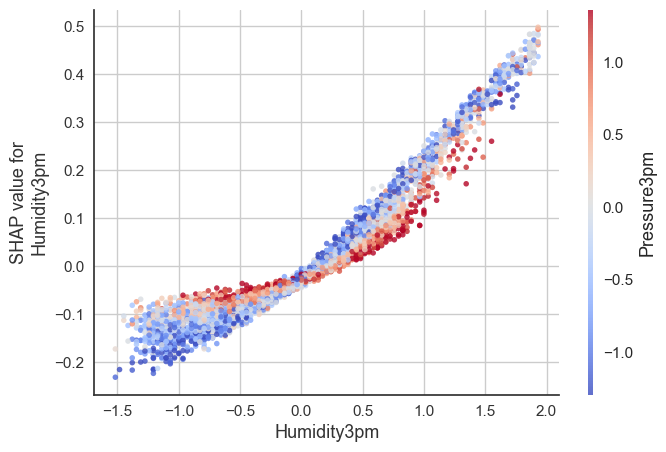

In [91]:
# Crear el gráfico de dependencia con colores personalizados en SHAP
shap.dependence_plot(
    "Humidity3pm",  # Nombre de la característica
    shap_values[:,:,0],  # Valores SHAP para la clase 0
    X_test_scaled,
    cmap='coolwarm',
    alpha=0.8,
    show=True
)

Aqui se muestra la clara relacion entre la variable que segun shap mas afecta al modelo.

#### Global

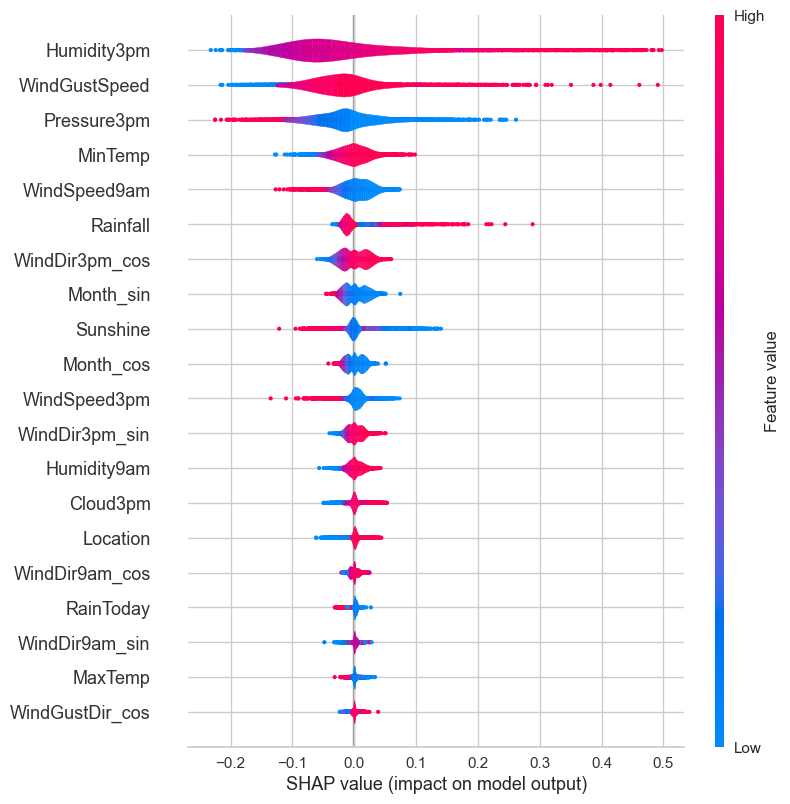

In [92]:
shap.violin_plot(shap_values[:,:,0], X_test_scaled)

En este grafico podemos ver de manera mas general como afectan las variables al modelo


### Red Neuronal vs. Regresión Logística | Observaciones clave:

1. **Importancia global de las características:**
   - En el modelo de **regresión logística**, las características más influyentes son `Humidity3pm`, `WindGustSpeed`, `Pressure3pm` y `WindSpeed9am`.
   - En la **red neuronal**, las mismas características (`Humidity3pm`, `WindGustSpeed`, `Pressure3pm`) también destacan como importantes, pero hay una mayor dispersión en la relevancia entre varias características adicionales, como `Rainfall` y `Sunshine`.
   - Esto sugiere que la red neuronal puede capturar patrones más complejos al considerar un mayor número de características relevantes.

2. **Distribución de los valores SHAP:**
   - En la regresión logística, los valores SHAP tienen una mayor amplitud y alcanzan un rango más amplio (por ejemplo, `Humidity3pm` varía entre -3 y 4).
   - En la red neuronal, los valores SHAP son más pequeños en magnitud (principalmente entre -0.2 y 0.5), reflejando que el modelo distribuye su impacto entre múltiples características.
   - Esto puede indicar que:
     - En la regresión logística, las predicciones están más directamente influenciadas por algunas características específicas.
     - En la red neuronal, las predicciones reflejan una interacción más compleja y conjunta de las características.

3. **Número de características relevantes:**
   - En la regresión logística, unas pocas características dominan el impacto global del modelo.
   - En la red neuronal, muchas características tienen un impacto más distribuido, con contribuciones moderadas pero significativas en varias de ellas.
   - Esto es consistente con la naturaleza de las redes neuronales, que pueden manejar relaciones no lineales entre características.

4. **Relación entre el valor de la característica y su impacto:**
   - En ambos gráficos, los colores reflejan el valor de las características (alto en rojo, bajo en azul).
   - En la regresión logística, las relaciones son más lineales, con un efecto más directo de las características individuales sobre el resultado.
   - En la red neuronal, los patrones son más complejos y no siempre lineales, con contribuciones positivas y negativas dependiendo del contexto y las combinaciones de características.

#### Conclusión:
- **Regresión Logística:** Es más interpretable debido a la naturaleza lineal de las relaciones que modela. Los efectos de las características individuales son más claros y predecibles.
- **Red Neuronal:** Aunque menos intuitiva, destaca por su capacidad para capturar interacciones no lineales y relaciones más complejas en los datos. SHAP es crucial para entender cómo las características influyen en las predicciones en este tipo de modelo.





## Comparación de Modelos utilizando F1-Score

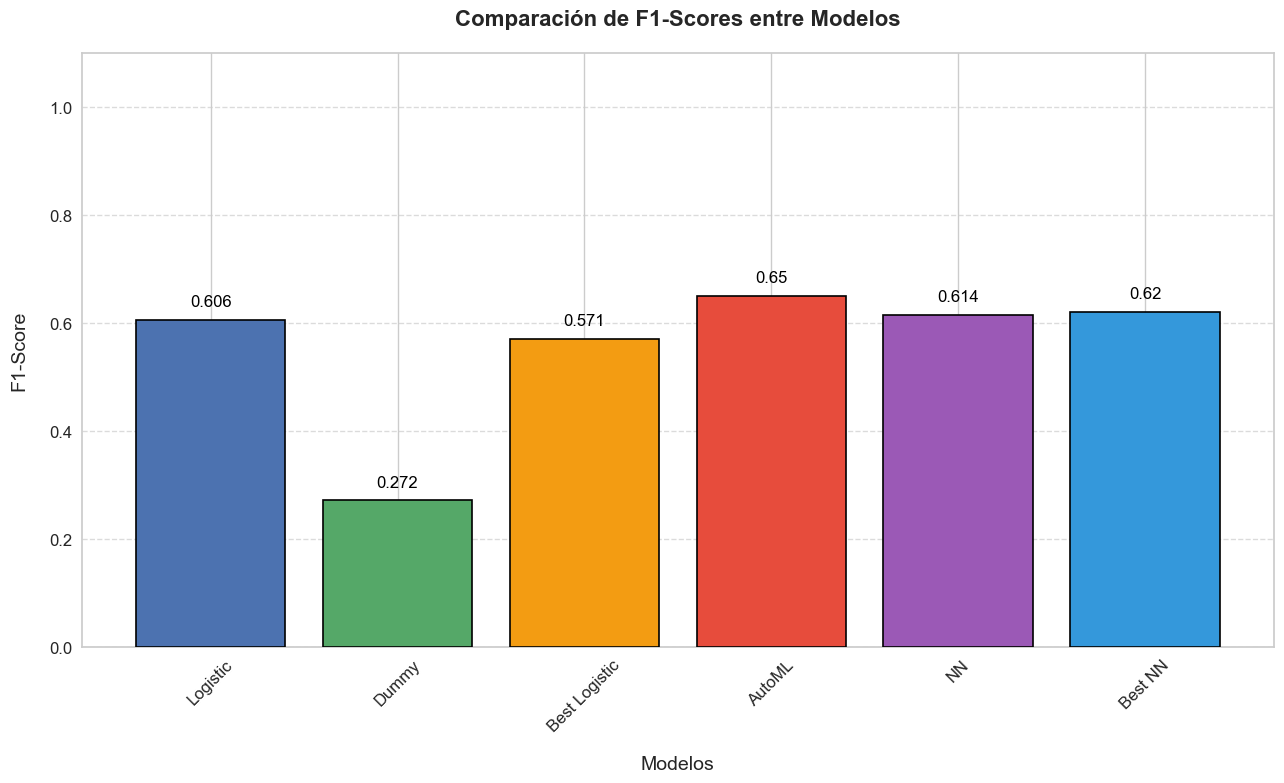

In [93]:

# Datos de los modelos y F1-scores
models = ['Logistic', 'Dummy', 'Best Logistic', 'AutoML', 'NN', 'Best NN']
f1_scores = [f1_logistic, f1_dummy_balanced, best_f1_logistic, best_f1_automl, f1_nn, f1_best_nn]

# Definir colores y estilo
colors = ['#4C72B0', '#55A868', '#F39C12', '#E74C3C', '#9B59B6', '#3498DB']
fig, ax = plt.subplots(figsize=(13, 8))

# Crear el gráfico de barras con bordes redondeados
bars = ax.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=1.2, zorder=3)

# Añadir etiquetas sobre las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 3), ha='center', va='bottom', fontsize=12, color='black', zorder=4)

# Configuración del gráfico
ax.set_title('Comparación de F1-Scores entre Modelos', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Modelos', fontsize=14, labelpad=15)
ax.set_ylabel('F1-Score', fontsize=14, labelpad=15)
ax.set_ylim(0, 1.1)  # Ampliar el límite superior para dejar espacio a las etiquetas
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Agregar un grid para facilitar la lectura
ax.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el gráfico para evitar que se solapen los textos
plt.show()


En este grafico observamos la ventaja de los modelos AutoML y NN de manera clara

Decidimos usar la métrica **F1-Score** porque equilibra precisión y recall, penalizando tanto los falsos positivos como los falsos negativos. Esto nos da una evaluación más completa del rendimiento de los modelos. Basándonos en los resultados, respondemos las siguientes preguntas:

### 1. **¿Cuál es el modelo con mejor desempeño?**

El modelo **AutoML** mostró el mejor desempeño en términos de F1-Score con un valor de **0.65**, superando a los demás modelos evaluados. Es seguido de cerca por el modelo **NN** (Red Neuronal), con un F1-Score de **0.608**.

### 2. **¿Por qué los modelos AutoML y NN tienen un mejor desempeño?**

- El modelo **AutoML** realiza una optimización exhaustiva de hiperparámetros y estrategias de preprocesamiento, permitiendo encontrar configuraciones ideales para los datos del problema.
- La **Red Neuronal** probablemente se benefició de su capacidad inherente para aprender representaciones más complejas en los datos, aunque sin optimización adicional no alcanza el nivel de AutoML.

### 3. **¿Qué modelos tuvieron el peor desempeño?**

El modelo **Dummy** tiene el peor desempeño con un F1-Score de **0.272**, lo cual es esperado ya que es un modelo base que no aprende de los datos. Por otro lado, el modelo **Best Logistic** (regresión logística optimizada) logró un F1-Score de **0.571**, que es notablemente mejor que el Dummy, pero inferior a los modelos más avanzados.

### 4. **¿Existen diferencias sustanciales entre los modelos?**

Sí, las diferencias son claras. Mientras que AutoML y NN superan la barrera de **0.6** en el F1-Score, los modelos como Logistic (0.606) y Best Logistic (0.571) quedan rezagados. Esto sugiere que, aunque los modelos simples son competitivos, los más avanzados logran un mejor desempeño al aprovechar su capacidad para manejar datos complejos y ajustar hiperparámetros de manera óptima.


## MLOps

Guardamos los archivos serializados

In [ ]:
"""# Guardar el modelo entrenado
with open("modelo.pkl", "wb") as f:
    pickle.dump(best_nn, f)

# Guardar el scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
    
with open("mean_encoded_location.pkl", "wb") as f:
    pickle.dump(mean_encoded_location_today, f)
  
with open("medias.pkl", "wb") as f:
    pickle.dump(medias, f)

with open("mediana_sunshine.pkl", "wb") as f:
    pickle.dump(mediana_sunshine, f)

with open("mediana_evaporation.pkl", "wb") as f:
    pickle.dump(mediana_evaporation, f)

with open("knn_imputer.pkl", "wb") as f:
    pickle.dump(knn_imputer, f)"""